In [1]:
# 1. Importamos los paquetes necesarios
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

from scipy.stats import mannwhitneyu



In [2]:
# FUNCIONES:  
# Función para graficar columnas categóricas con el mismo color
BASE_COLORS = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#b3b3cc', '#f781bf']
def graficar_columna_categorica(df, columna, titulo=None):
    """
    Genera un gráfico de barras con colores diferenciados y sin leyenda,
    adaptando los colores al número de categorías de la columna.

    Parámetros:
        df: DataFrame de entrada
        columna: str, nombre de la columna categórica a graficar
        titulo: str, título del gráfico
    """
    # Contar valores de la columna
    conteo = df[columna].value_counts()
    categorias_colors = conteo.index.tolist()

    # Ajustar la paleta según número de categorías
    colores = BASE_COLORS[:len(categorias_colors)]

    # Crear gráfico
    plt.figure(figsize=(8, 4))
    plt.bar(categorias_colors, conteo.values, color=colores)
    
    # Estética
    plt.title(titulo or f'{columna} distribution')
    plt.xlabel(columna.replace('_', ' ').title())
    plt.ylabel('Players')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Función para unificar los valores de "devices" y limpiarlos
def limpiar_dispositivos_orden_personalizado(col):
    orden = ['PC', 'Console', 'Mobile']
    mapa_final = {'pc': 'PC', 'console': 'Console', 'mobile': 'Mobile'}

    def procesar(x):
        if pd.isna(x):
            return ""
        x = str(x).lower()
        x = x.replace('console (playstation, xbox, etc.)', 'console')
        x = x.replace('handheld devices (nintendo switch, etc.)', 'console')
        x = x.replace('tablet', 'mobile')
        x = x.replace('all', 'pc, mobile, console')
        dispositivos_raw = [d.strip() for d in x.replace(', ', ',').replace(' ,', ',').split(',')]
        dispositivos = [mapa_final.get(d, d.capitalize()) for d in dispositivos_raw]
        dispositivos = list(set(dispositivos))  # eliminar duplicados
        dispositivos_ordenados = [d for d in orden if d in dispositivos]
        return ', '.join(dispositivos_ordenados) if dispositivos_ordenados else ""

    return col.apply(procesar)

    

# Función para recombrar columnas repetidas con sufijos
def renombrar_repetidas_con_sufijos(df, mantener_sin_sufijo=None):
    if mantener_sin_sufijo is None:
        mantener_sin_sufijo = []

    nombre_counts = {}
    nuevos_nombres = []

    for col in df.columns:
        if col in mantener_sin_sufijo:
            nuevos_nombres.append(col)
        else:
            if col not in nombre_counts:
                nombre_counts[col] = 1
                nuevos_nombres.append(f"{col}_1")
            else:
                nombre_counts[col] += 1
                nuevos_nombres.append(f"{col}_{nombre_counts[col]}")

    df.columns = nuevos_nombres
    return df

# Función de limpieza de géneros
mapa_generos = {
    'first-person shooter (fps)': 'First-Person Shooter',
    'fps': 'First-Person Shooter',
    'action/adventure': 'Action-Adventure',
    'action adventure': 'Action-Adventure',
    'puzzle/strategy': 'Puzzle-Strategy',
    'simulation (e.g., the sims)': 'Simulation',
    'simulation': 'Simulation',
    'sports': 'Sports',
    'mmo (massively multiplayer online)': 'MMO',
    'role-playing games (rpg)': 'Role-Playing',
    'role-playing': 'Role-Playing',
    'rpg': 'Role-Playing',
    'casual': 'Casual',
    'horror': 'Horror',
    # en caso de que alguien haya escrito todo junto
    'action/adventure, sports': 'Action-Adventure, Sports'
}

def limpiar_generos(col):
    def procesar(x):
        if pd.isna(x):
            return None
        x = str(x).lower()
        generos_raw = [g.strip() for g in x.replace(', ', ',').replace(' ,', ',').split(',')]
        generos_norm = [mapa_generos.get(g, g.title()) for g in generos_raw]
        generos_unicos = sorted(set(generos_norm))
        return ', '.join(generos_unicos)
    
    return col.apply(procesar)

# Función de limpieza de juegos favoritos
mapa_juegos = {
    'Call Of Duty': 'Call Of Duty',
    'CALL OF DUTY': 'Call Of Duty',
    'call of duty': 'Call Of Duty',

    'Fornite': 'Fortnite',
    'Fortnite': 'Fortnite',

    'efootball': 'Efootball',
    'Efootball': 'Efootball',

    'FC MOBILE': 'FC Mobile',
    'Fc Mobile': 'FC Mobile',

    'Solo leveling arise': 'Solo Leveling',
    'Solo Levelling': 'Solo Leveling',

    'Wuthering waves': 'Wuthering Waves',
    'Wuther Waves': 'Wuthering Waves',

    'Rhythm Rush lite': 'Rhythm Rush Lite',
    'Wukong': 'Wukong',
    'Subway': 'Subway',
    'Many': 'Many',
    'BGMI': 'BGMI',
    'bgmi,coc,chess': 'BGMI, COC, Chess',
    'Moba Legends': 'MOBA Legends',
    'Red dead redemption 2': 'Red Dead Redemption 2',
    'God of war ragnarok': 'God Of War Ragnarok',
    'Chess and clash of clans': 'Chess And Clash Of Clans',
    'Free fire,wuthering waves': 'Free Fire, Wuthering Waves',

    # Juegos del favorite_game_2
    'FIFA 2024': 'FIFA',
    'Call of Duty': 'Call Of Duty',
    'Overwatch': 'Overwatch',
    'League of Legends': 'League Of Legends',
    'Minecraft': 'Minecraft',
    'Genshin Impact': 'Genshin Impact',
    'Apex Legends': 'Apex Legends',
    'Among Us': 'Among Us',
    'Valorant': 'Valorant'
}

# Función para limpiar y mapear juegos favoritos
def limpiar_favorite_game(col):
    return col.str.strip().str.title().replace(mapa_juegos)

# Función para limpiar y mapear motivaciones
mapa_motivation = {
    'for fun/entertainment': 'Fun',
    'to relieve stress': 'Stress Relief',
    'to socialize': 'Socializing',
    'to socialize with friends': 'Socializing',
    'to improve skills/competition': 'Competition',
    "learning how it's designed": 'Learning',
    'for the story/experience': 'Story',
    'if no other better work': 'Other'
}

def limpiar_motivation(col):
    def procesar(x):
        if pd.isna(x):
            return None
        x = str(x).lower()
        items = [i.strip() for i in x.replace(', ', ',').replace(' ,', ',').split(',')]
        normalizados = [mapa_motivation.get(i, i.title()) for i in items]
        return ', '.join(sorted(set(normalizados)))
    return col.apply(procesar)

# Función definir cardinalidad
def card_tipo(df,umbral_categoria = 10, umbral_continua = 30):
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) 
    df_temp = df_temp.T 
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) 

    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

   
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"


    return df_temp

In [3]:
# Paleta de colores en las gráficas
BASE_COLORS = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#b3b3cc', '#f781bf']

In [4]:
# 2. Importamos el archivo xlsx y lo convertimos en DataFrame
df = pd.read_excel('./src/data/Gaming_Survey.xlsx')

In [5]:
# 3. Dimensiones del dataset
print(f"Filas y columnas: {df.shape}")

Filas y columnas: (500, 22)


In [6]:
# 4. Primeras filas del dataset
print("\nPrimeras filas:")
display(df.head())


Primeras filas:


,Timestamp,Age,Gender,Location,How often do you play video games?,How many hours do you typically spend gaming in a week?,Which device do you play games on the most?(Check all that apply),What genres of video games do you play? (Check all that apply),What is your favorite game?,How do you discover new games? (Check all that apply),...,Why do you play video games? (Check all that apply),How often do you play video games?,How many hours do you typically spend gaming in a week?,Which device do you play games on the most?(Check all that apply),What genres of video games do you play? (Check all that apply),What is your favorite game?,How do you discover new games? (Check all that apply),Do you prefer single-player or multiplayer games?,"How much do you spend on gaming monthly (including in-game purchases, new games, etc.)?",Why do you play video games? (Check all that apply)
0,2024-10-24 13:09:27.109,18,Male,Bangalore,Daily,10-20 hours,Mobile,Sports,FC MOBILE,"Social Media, Gaming Forums",...,"For fun/entertainment, To relieve stress",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-24 13:09:34.343,19,Male,"Hell road , Bangalore",Rarely/Never,0,Mobile,"Puzzle/Strategy, Simulation (e.g., The Sims)",Wukong,Social Media,...,To improve skills/competition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-24 13:23:13.403,19,Male,Bangalore,Rarely/Never,More than 20 hours,"Console (PlayStation, Xbox, etc.)",First-Person Shooter (FPS),Call of duty,Gaming Forums,...,For fun/entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-24 13:30:42.445,18,Female,Banglore,Rarely/Never,Less than 5 hours,Mobile,Puzzle/Strategy,Subway,Social Media,...,For fun/entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-24 13:32:26.815,18,Female,"Banglore, Karnataka",Daily,Less than 5 hours,"PC, Mobile","Action/Adventure, First-Person Shooter (FPS), ...",Solo leveling arise,Friends/Family Recommendations,...,"For fun/entertainment, To relieve stress, To s...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 5. Tipos de datos
print("\nTipos de datos:")
print(df.dtypes)


Tipos de datos:
Timestamp                                                                                     datetime64[ns]
Age                                                                                                    int64
Gender                                                                                                object
Location                                                                                              object
  How often do you play video games?                                                                  object
  How many hours do you typically spend gaming in a week?                                             object
  Which device do you play games on the most?(Check all that apply)                                   object
What genres of video games do you play? (Check all that apply)                                        object
  What is your favorite game?                                                                         object
Ho

In [8]:
# 6. Información general del dataset
print("\nInformación general:")
print(df.info())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 22 columns):
 #   Column                                                                                      Non-Null Count  Dtype         
---  ------                                                                                      --------------  -----         
 0   Timestamp                                                                                   500 non-null    datetime64[ns]
 1   Age                                                                                         500 non-null    int64         
 2   Gender                                                                                      500 non-null    object        
 3   Location                                                                                    500 non-null    object        
 4     How often do you play video games?                                                        500 non-

In [9]:
# 7. Porcentaje de valores nulos por columna
print("\nPorcentaje de valores nulos por columna:")
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage.sort_values(ascending=False))


Porcentaje de valores nulos por columna:
Why do you play video games? (Check all that apply)                                           40.0
How much do you spend on gaming monthly (including in-game purchases, new games, etc.)?       40.0
Do you prefer single-player or multiplayer games?                                             40.0
How do you discover new games? (Check all that apply)                                         40.0
What is your favorite game?                                                                   40.0
What genres of video games do you play? (Check all that apply)                                40.0
Which device do you play games on the most?(Check all that apply)                             40.0
How many hours do you typically spend gaming in a week?                                       40.0
How often do you play video games?                                                            40.0
Age                                                                

In [10]:
# 8. Eliminamos espacios antes y después de cada nombre de las columnas para poder procesarlos
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Timestamp', 'Age', 'Gender', 'Location',
       'How often do you play video games?',
       'How many hours do you typically spend gaming in a week?',
       'Which device do you play games on the most?(Check all that apply)',
       'What genres of video games do you play? (Check all that apply)',
       'What is your favorite game?',
       'How do you discover new games? (Check all that apply)',
       'Do you prefer single-player or multiplayer games?',
       'How much do you spend on gaming monthly (including in-game purchases, new games, etc.)?',
       'Why do you play video games? (Check all that apply)',
       'How often do you play video games?',
       'How many hours do you typically spend gaming in a week?',
       'Which device do you play games on the most?(Check all that apply)',
       'What genres of video games do you play? (Check all that apply)',
       'What is your favorite game?',
       'How do you discover new games? (Check all that apply)',
       

In [11]:
# 9. Vemos que hay columnas repetidas. Esto puede ser debido a que, al haber sido rellenado con un formulario, cada jugador eligió uno o dos juegos para la encuesta.
# Renombramos las columnas repetidas, para que sea mas eficiente a la hora de analizar los datos.
nombres_cortos = {
    'Timestamp': 'timestamp',
    'Age': 'age',
    'Gender': 'gender',
    'Location': 'location',
    'How often do you play video games?': 'frequency',
    'How many hours do you typically spend gaming in a week?': 'hours_per_week',
    'Which device do you play games on the most?(Check all that apply)': 'device',
    'What genres of video games do you play? (Check all that apply)': 'genres',
    'What is your favorite game?': 'favorite_game',
    'How do you discover new games? (Check all that apply)': 'discovery',
    'Why do you play video games? (Check all that apply)': 'motivation',
    'Do you prefer single-player or multiplayer games?': 'game_mode',
    'How much do you spend on gaming monthly (including in-game purchases, new games, etc.)?': 'monthly_spend'
}

df.rename(columns=nombres_cortos, inplace=True)

df.head()

,timestamp,age,gender,location,frequency,hours_per_week,device,genres,favorite_game,discovery,...,motivation,frequency,hours_per_week,device,genres,favorite_game,discovery,game_mode,monthly_spend,motivation
0,2024-10-24 13:09:27.109,18,Male,Bangalore,Daily,10-20 hours,Mobile,Sports,FC MOBILE,"Social Media, Gaming Forums",...,"For fun/entertainment, To relieve stress",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-24 13:09:34.343,19,Male,"Hell road , Bangalore",Rarely/Never,0,Mobile,"Puzzle/Strategy, Simulation (e.g., The Sims)",Wukong,Social Media,...,To improve skills/competition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-24 13:23:13.403,19,Male,Bangalore,Rarely/Never,More than 20 hours,"Console (PlayStation, Xbox, etc.)",First-Person Shooter (FPS),Call of duty,Gaming Forums,...,For fun/entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-24 13:30:42.445,18,Female,Banglore,Rarely/Never,Less than 5 hours,Mobile,Puzzle/Strategy,Subway,Social Media,...,For fun/entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-24 13:32:26.815,18,Female,"Banglore, Karnataka",Daily,Less than 5 hours,"PC, Mobile","Action/Adventure, First-Person Shooter (FPS), ...",Solo leveling arise,Friends/Family Recommendations,...,"For fun/entertainment, To relieve stress, To s...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 10. Hacemos copia del df original para manipular los datos y poder volver atrás si nos equivocamos
df_copia = df.copy()

In [13]:
# 11. Sobre la copia del df original, renombramos las columnas duplicadas para diferenciar entre "Juego 1" y "Juego 2"
# Columnas que NO queremos que lleven número
fijas = ['timestamp', 'age', 'gender', 'location']

# Aplicar renombrado
df_copia = renombrar_repetidas_con_sufijos(df_copia, mantener_sin_sufijo=fijas)

print(df_copia.columns.tolist())


['timestamp', 'age', 'gender', 'location', 'frequency_1', 'hours_per_week_1', 'device_1', 'genres_1', 'favorite_game_1', 'discovery_1', 'game_mode_1', 'monthly_spend_1', 'motivation_1', 'frequency_2', 'hours_per_week_2', 'device_2', 'genres_2', 'favorite_game_2', 'discovery_2', 'game_mode_2', 'monthly_spend_2', 'motivation_2']


In [14]:
# 12. La columna timestamp es irrelevante para nuestro análisis, ya que no es importante en qué fecha se rellenó cada encuesta, así que la eliminamos
df_copia.drop(columns=['timestamp'], inplace=True)

# Resetear índice y eliminar el anterior
df_copia.reset_index(drop=True, inplace=True)

# Confirmar
df_copia.head()

,age,gender,location,frequency_1,hours_per_week_1,device_1,genres_1,favorite_game_1,discovery_1,game_mode_1,...,motivation_1,frequency_2,hours_per_week_2,device_2,genres_2,favorite_game_2,discovery_2,game_mode_2,monthly_spend_2,motivation_2
0,18,Male,Bangalore,Daily,10-20 hours,Mobile,Sports,FC MOBILE,"Social Media, Gaming Forums",Both,...,"For fun/entertainment, To relieve stress",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,Male,"Hell road , Bangalore",Rarely/Never,0,Mobile,"Puzzle/Strategy, Simulation (e.g., The Sims)",Wukong,Social Media,Single-player,...,To improve skills/competition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,Male,Bangalore,Rarely/Never,More than 20 hours,"Console (PlayStation, Xbox, etc.)",First-Person Shooter (FPS),Call of duty,Gaming Forums,Multiplayer,...,For fun/entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18,Female,Banglore,Rarely/Never,Less than 5 hours,Mobile,Puzzle/Strategy,Subway,Social Media,Both,...,For fun/entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18,Female,"Banglore, Karnataka",Daily,Less than 5 hours,"PC, Mobile","Action/Adventure, First-Person Shooter (FPS), ...",Solo leveling arise,Friends/Family Recommendations,Multiplayer,...,"For fun/entertainment, To relieve stress, To s...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# 13. Vamos a limpiar los datos de "gender" para que todos tengan el mismo formato
df_copia['gender'].unique()

array(['Male', 'Female', 'male'], dtype=object)

In [16]:
# El valor 'male' está en minúscula, así que vamos a unificarlo
df_copia['gender'] = df_copia['gender'].str.strip().str.lower().str.capitalize()
df_copia['gender'].value_counts()

gender
Female    268
Male      232
Name: count, dtype: int64

In [17]:
# 14. Ahora vamos a limpiar los datos de "location" para que todos tengan el mismo formato
df_copia['location'].unique()

array(['Bangalore', 'Hell road , Bangalore ', 'Banglore',
       'Banglore, Karnataka ', 'Bangalore ', 'Jain University ',
       'bangalore', 'Harohalli',
       'Nayapalli n4/8 near balaram medecine store bhubaneswar,odisha,India',
       'Odisha,Bhubaneswar ', 'Karnataka ', 'Andhra Pradesh', 'banglore',
       'Bhubaneswar, odisha ', 'Banglore ', 'karnataka', 'Karnataka',
       'Hell road , Bangalore', 'Banglore, Karnataka', 'Jain University',
       'bhubaneswar,odisha,India', 'Odisha,Bhubaneswar',
       'Bhubaneswar, odisha', 'Chennai', 'Kolkata', 'Pune', 'Hyderabad',
       'Mumbai', 'Ahmedabad', 'Delhi', 'Florida', 'London', 'Ohio',
       'Texas', 'New York', 'Toronto', 'California'], dtype=object)

In [18]:
correcciones_location = {
    'Banglore': 'Bangalore',
    'Banglore ': 'Bangalore',
    'banglore': 'Bangalore',
    'Banglore, Karnataka': 'Bangalore',
    'Banglore, Karnataka ': 'Bangalore',
    'Bangalore ': 'Bangalore',
    'bangalore': 'Bangalore',
    'Hell road , Bangalore': 'Bangalore',
    'Hell road , Bangalore ': 'Bangalore',

    'Karnataka ': 'Karnataka',
    'karnataka': 'Karnataka',

    'Bhubaneswar, odisha': 'Bhubaneswar',
    'bhubaneswar,odisha,India': 'Bhubaneswar',
    'Bhubaneswar, odisha ': 'Bhubaneswar',
    'Odisha,Bhubaneswar': 'Bhubaneswar',
    'Odisha,Bhubaneswar ': 'Bhubaneswar',
    'Nayapalli n4/8 near balaram medecine store bhubaneswar,odisha,India': 'Bhubaneswar',

    'Jain University ': 'Jain University',

    'Harohalli': 'Harohalli',
    'Andhra Pradesh': 'Andhra Pradesh',
    'Chennai': 'Chennai',
    'Kolkata': 'Kolkata',
    'Pune': 'Pune',
    'Hyderabad': 'Hyderabad',
    'Mumbai': 'Mumbai',
    'Ahmedabad': 'Ahmedabad',
    'Delhi': 'Delhi',
    'Florida': 'Florida',
    'London': 'London',
    'Ohio': 'Ohio',
    'Texas': 'Texas',
    'New York': 'New York',
    'Toronto': 'Toronto',
    'California': 'California'
}

df_copia['location'] = df_copia['location'].str.strip()  # eliminar espacios
df_copia['location'] = df_copia['location'].replace(correcciones_location)

In [19]:
print(df_copia['location'].value_counts())

location
Bangalore          89
Mumbai             50
Delhi              48
New York           36
London             32
Ohio               32
Florida            30
Toronto            25
Texas              25
Pune               20
Hyderabad          20
Kolkata            19
Chennai            18
California         17
Ahmedabad          13
Bhubaneswar         9
Karnataka           8
Jain University     3
Andhra Pradesh      3
Harohalli           3
Name: count, dtype: int64


In [20]:
# 15. Vamos a limpiar los datos de "frequency_1" y "frequency_2" para que todos tengan el mismo formato
df_copia['frequency_1'].unique()

array(['Daily', 'Rarely/Never', 'A few times in a week',
       'A few times in a month', 'A few times a week'], dtype=object)

In [21]:
# Vemos que 'A few times in a week' y 'A few times a week' deberían ser lo mismo, pero están escritos de forma distinta.
correcciones_frequency = {
    'A few times in a week': 'A few times a week'
}

# Limpiar espacios y aplicar corrección
df_copia['frequency_1'] = df_copia['frequency_1'].str.strip()
df_copia['frequency_1'] = df_copia['frequency_1'].replace(correcciones_frequency)

df_copia['frequency_1'].value_counts()

frequency_1
Daily                     209
A few times a week        150
Rarely/Never              121
A few times in a month     20
Name: count, dtype: int64

In [22]:
# Hacemos lo mismo con 'frequency_2' y vemos que, en este caso, los valores son diferentes
df_copia['frequency_2'].value_counts()


frequency_2
Daily           107
Rarely/Never     98
Weekly           95
Name: count, dtype: int64

In [23]:
# Unificamos los valores para que sean consistentes
correcciones_frequency = {
    'A few times a week': 'Weekly',
    'A few times in a month': 'Monthly'
}

df_copia['frequency_1'] = df_copia['frequency_1'].replace(correcciones_frequency)
df_copia['frequency_1'].value_counts()

frequency_1
Daily           209
Weekly          150
Rarely/Never    121
Monthly          20
Name: count, dtype: int64

In [24]:
# 16. Hacemos lo mismo con los datos de "hours_per_week_1" y "hours_per_week_2" para que todos tengan el mismo formato
print(df_copia['hours_per_week_1'].unique())
print(df_copia['hours_per_week_2'].unique())

['10-20 hours' 0 'More than 20 hours' 'Less than 5 hours' '30mins'
 '5-10 hours']
[nan '5-10 hours' 'Less than 5 hours' '10-20 hours' 'More than 20 hours']


In [25]:
correcciones_horas = {
    '30mins': 'Less than 1 hour',
    '0': '0 hours',
    '0.0': '0 hours',
    'None': '0 hours',
    'Less than 5 hours': '1–5 hours',
    '5-10 hours': '5–10 hours',
    '10-20 hours': '10–20 hours'
    # 'More than 20 hours' ya está bien
}

# Limpiar y reemplazar en hours_per_week_1
df_copia['hours_per_week_1'] = df_copia['hours_per_week_1'].astype(str).str.strip()
df_copia['hours_per_week_1'] = df_copia['hours_per_week_1'].replace(correcciones_horas)

# Limpiar y reemplazar en hours_per_week_2
df_copia['hours_per_week_2'] = df_copia['hours_per_week_2'].astype(str).str.strip()
df_copia['hours_per_week_2'] = df_copia['hours_per_week_2'].replace(correcciones_horas)

print(df_copia['hours_per_week_1'].value_counts())
print(df_copia['hours_per_week_2'].value_counts())

hours_per_week_1
5–10 hours            161
10–20 hours           135
1–5 hours             112
More than 20 hours     80
0 hours                 6
Less than 1 hour        6
Name: count, dtype: int64
hours_per_week_2
nan                   200
1–5 hours              80
More than 20 hours     78
10–20 hours            72
5–10 hours             70
Name: count, dtype: int64


In [26]:
# 17. Vamos ahora con los datos de "device_1" y "device_2"
print(df_copia['device_1'].unique())
print(df_copia['device_2'].unique())

['Mobile' 'Console (PlayStation, Xbox, etc.)' 'PC, Mobile'
 'Console (PlayStation, Xbox, etc.), Mobile'
 'Console (PlayStation, Xbox, etc.), Handheld devices (Nintendo Switch, etc.)'
 'PC' 'PC, Console (PlayStation, Xbox, etc.), Mobile' 'Console, Mobile'
 'Tablet' 'PC, Console']
[nan 'PC, Console' 'PC, Mobile' 'All' 'Console (PlayStation, Xbox, etc.)'
 'Mobile, Console' 'Mobile' 'PC']


In [27]:
# Creo una copia de seguridad por si acaso
df_copia_3 = df_copia.copy()

In [28]:
df_copia_3['device_1'] = limpiar_dispositivos_orden_personalizado(df_copia_3['device_1'])
df_copia_3['device_2'] = limpiar_dispositivos_orden_personalizado(df_copia_3['device_2'])

print(df_copia_3['device_1'].value_counts())
print(df_copia_3['device_2'].value_counts())


device_1
Mobile                 176
PC, Mobile              89
Console                 65
Console, Mobile         65
PC                      51
PC, Console             44
PC, Console, Mobile     10
Name: count, dtype: int64
device_2
                       200
Console                 47
PC, Mobile              46
PC, Console, Mobile     45
Mobile                  45
PC, Console             43
Console, Mobile         41
PC                      33
Name: count, dtype: int64


In [29]:
# 18. Ahora vamos con "genres"
print(df_copia_3['genres_1'].value_counts())


genres_1
Sports                                                                                                                                                      46
First-Person Shooter (FPS)                                                                                                                                  45
Action/Adventure, Role-Playing Games (RPG)                                                                                                                  42
Action/Adventure, First-Person Shooter (FPS)                                                                                                                40
Puzzle/Strategy                                                                                                                                             23
Action/Adventure, First-Person Shooter (FPS), Role-Playing Games (RPG)                                                                                      23
Action/Adventure, First-Person Shoote

In [30]:
print(df_copia_3['genres_2'].value_counts())

genres_2
Simulation                    42
Action/Adventure              42
Puzzle/Strategy               41
First-Person Shooter (FPS)    40
Role-playing                  36
Horror                        35
Sports                        34
Casual                        30
Name: count, dtype: int64


In [31]:
# Vemos que hay muchos géneros diferentes asi que vamos a agruparlos y limpiarlos
mapa_generos = {
    'first-person shooter (fps)': 'First-Person Shooter',
    'fps': 'First-Person Shooter',
    'action/adventure': 'Action-Adventure',
    'action adventure': 'Action-Adventure',
    'puzzle/strategy': 'Puzzle-Strategy',
    'simulation (e.g., the sims)': 'Simulation',
    'simulation': 'Simulation',
    'sports': 'Sports',
    'mmo (massively multiplayer online)': 'MMO',
    'role-playing games (rpg)': 'Role-Playing',
    'role-playing': 'Role-Playing',
    'rpg': 'Role-Playing',
    'casual': 'Casual',
    'horror': 'Horror',
    # en caso de que alguien haya escrito todo junto
    'action/adventure, sports': 'Action-Adventure, Sports'
}

def limpiar_generos(col):
    def procesar(x):
        if pd.isna(x):
            return None
        x = str(x).lower()
        generos_raw = [g.strip() for g in x.replace(', ', ',').replace(' ,', ',').split(',')]
        generos_norm = [mapa_generos.get(g, g.title()) for g in generos_raw]
        generos_unicos = sorted(set(generos_norm))
        return ', '.join(generos_unicos)
    
    return col.apply(procesar)

In [32]:
# Creamos copia de seguridad por si acaso
df_copia_5 = df_copia_3.copy()

In [33]:
# 19. Vamos a limpiar ahora las columnas "favorite_game_1" y "favorite_game_2"
print(df_copia_5['favorite_game_1'].value_counts(dropna=False))
print(df_copia_5['favorite_game_2'].value_counts(dropna=False))

favorite_game_1
FC MOBILE                    23
Call of duty                 23
Subway                       23
Solo leveling arise          23
Efootball                    23
Call of duty                 23
call of duty                 23
Wukong                       23
Rhythm Rush lite             22
Wuthering waves              22
CALL OF DUTY                 22
Solo Levelling               22
Wuther waves                 22
Free fire,wuthering waves    22
Moba Legends                 22
BGMI                         22
Red dead redemption 2        20
Chess and clash of clans     20
God of war ragnarok          20
fornite                      20
bgmi,coc,chess               20
efootball                    20
Many                         20
Name: count, dtype: int64
favorite_game_2
NaN                  200
FIFA 2024             42
Call of Duty          39
Overwatch             35
League of Legends     31
Minecraft             29
Genshin Impact        27
Apex Legends          27
Fortni

In [34]:
# Hacemos copia de seguridad por si acaso
df_copia_6 = df_copia_5.copy()

In [35]:
mapa_juegos = {
    'Call Of Duty': 'Call Of Duty',
    'CALL OF DUTY': 'Call Of Duty',
    'call of duty': 'Call Of Duty',

    'Fornite': 'Fortnite',
    'Fortnite': 'Fortnite',

    'efootball': 'Efootball',
    'Efootball': 'Efootball',

    'FC MOBILE': 'FC Mobile',
    'Fc Mobile': 'FC Mobile',

    'Solo leveling arise': 'Solo Leveling',
    'Solo Levelling': 'Solo Leveling',

    'Wuthering waves': 'Wuthering Waves',
    'Wuther Waves': 'Wuthering Waves',

    'Rhythm Rush lite': 'Rhythm Rush Lite',
    'Wukong': 'Wukong',
    'Subway': 'Subway',
    'Many': 'Many',
    'BGMI': 'BGMI',
    'bgmi,coc,chess': 'BGMI, COC, Chess',
    'Moba Legends': 'MOBA Legends',
    'Red dead redemption 2': 'Red Dead Redemption 2',
    'God of war ragnarok': 'God Of War Ragnarok',
    'Chess and clash of clans': 'Chess And Clash Of Clans',
    'Free fire,wuthering waves': 'Free Fire, Wuthering Waves',

    # Juegos del favorite_game_2
    'FIFA 2024': 'FIFA',
    'Call of Duty': 'Call Of Duty',
    'Overwatch': 'Overwatch',
    'League of Legends': 'League Of Legends',
    'Minecraft': 'Minecraft',
    'Genshin Impact': 'Genshin Impact',
    'Apex Legends': 'Apex Legends',
    'Among Us': 'Among Us',
    'Valorant': 'Valorant'
}

def limpiar_favorite_game(col):
    return col.str.strip().str.title().replace(mapa_juegos)

In [36]:
df_copia_6['favorite_game_1'] = limpiar_favorite_game(df_copia_6['favorite_game_1'])
df_copia_6['favorite_game_2'] = limpiar_favorite_game(df_copia_6['favorite_game_2'])

print(df_copia_6['favorite_game_1'].value_counts())
print(df_copia_6['favorite_game_2'].value_counts())

favorite_game_1
Call Of Duty                 91
Wuthering Waves              44
Efootball                    43
Wukong                       23
FC Mobile                    23
Solo Leveling Arise          23
Subway                       23
Bgmi                         22
MOBA Legends                 22
Free Fire,Wuthering Waves    22
Rhythm Rush Lite             22
Solo Leveling                22
Red Dead Redemption 2        20
Chess And Clash Of Clans     20
God Of War Ragnarok          20
Fortnite                     20
Bgmi,Coc,Chess               20
Many                         20
Name: count, dtype: int64
favorite_game_2
Fifa 2024            42
Call Of Duty         39
Overwatch            35
League Of Legends    31
Minecraft            29
Genshin Impact       27
Apex Legends         27
Fortnite             26
Among Us             22
Valorant             22
Name: count, dtype: int64


In [37]:
# 20. Vamos a limpiar ahora las columnas "discovery_1" y "discovery_2"
print(df_copia_6['discovery_1'].unique())

['Social Media, Gaming Forums' 'Social Media' 'Gaming Forums'
 'Friends/Family Recommendations'
 'Social Media, Gaming Forums, Game Reviews/Blogs, YouTube/Streaming platforms (Twitch, etc.)'
 'Gaming Forums, YouTube/Streaming platforms (Twitch, etc.)'
 'Social Media, Friends/Family Recommendations'
 'Gaming Forums, Game Reviews/Blogs'
 'Social Media, Gaming Forums, Friends/Family Recommendations, Game Reviews/Blogs, YouTube/Streaming platforms (Twitch, etc.)'
 'I search myself from playstore '
 'Friends/Family Recommendations, YouTube/Streaming platforms (Twitch, etc.)'
 'YouTube/Streaming platforms (Twitch, etc.)'
 'Social Media, Gaming Forums, Game Reviews/Blogs, YouTube/Streaming platforms (Twitch, etc.), my own ways!!!']


In [38]:
print(df_copia_6['discovery_2'].unique())

[nan 'Friends/Family Recommendations' 'Gaming Forums' 'Social Media'
 'YouTube' 'Twitch']


In [39]:
# Hacemos copia de seguridad por si acaso
df_copia_8 = df_copia_6.copy()

In [40]:
# Creamos un nuevo df con la info de discovery 1 y discovery 2 para luego poder analizar esos datos y trabajar mejor sobre ellos
# 1. Obtener todas las categorías únicas de discovery_1 y discovery_2
# Las combinamos para evitar duplicados entre columnas
respuestas_1 = df_copia_8['discovery_1'].dropna().str.split(',').explode().str.strip()
respuestas_2 = df_copia_8['discovery_2'].dropna().str.split(',').explode().str.strip()

categorias_discovery = sorted(set(respuestas_1).union(set(respuestas_2)))
categorias_discovery

['Friends/Family Recommendations',
 'Game Reviews/Blogs',
 'Gaming Forums',
 'I search myself from playstore',
 'Social Media',
 'Twitch',
 'YouTube',
 'YouTube/Streaming platforms (Twitch',
 'etc.)',
 'my own ways!!!']

In [41]:
# 2. Crear columnas binarias para discovery_1 y discovery_2
df_discovery = pd.DataFrame(index=df_copia_8.index)

for cat in categorias_discovery:
    df_discovery[f'discovery1_{cat}'] = df_copia_8['discovery_1'].fillna('').apply(lambda x: int(cat in x))
    df_discovery[f'discovery2_{cat}'] = df_copia_8['discovery_2'].fillna('').apply(lambda x: int(cat in x))

# Eliminamos las columnas y las filas que solo tienen ceros
df_discovery = df_discovery.loc[:, (df_discovery != 0).any(axis=0)]
df_discovery = df_discovery.loc[df_discovery.sum(axis=1) > 0]
df_discovery.head()

,discovery1_Friends/Family Recommendations,discovery2_Friends/Family Recommendations,discovery1_Game Reviews/Blogs,discovery1_Gaming Forums,discovery2_Gaming Forums,discovery1_I search myself from playstore,discovery1_Social Media,discovery2_Social Media,discovery1_Twitch,discovery2_Twitch,discovery1_YouTube,discovery2_YouTube,discovery1_YouTube/Streaming platforms (Twitch,discovery1_etc.),discovery1_my own ways!!!
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
df_discovery.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype
---  ------                                          --------------  -----
 0   discovery1_Friends/Family Recommendations       500 non-null    int64
 1   discovery2_Friends/Family Recommendations       500 non-null    int64
 2   discovery1_Game Reviews/Blogs                   500 non-null    int64
 3   discovery1_Gaming Forums                        500 non-null    int64
 4   discovery2_Gaming Forums                        500 non-null    int64
 5   discovery1_I search myself from playstore       500 non-null    int64
 6   discovery1_Social Media                         500 non-null    int64
 7   discovery2_Social Media                         500 non-null    int64
 8   discovery1_Twitch                               500 non-null    int64
 9   discovery2_Twitch                               500 non-null    int64


In [43]:
df_discovery['discovery1_Recommendations'] = df_discovery.get('discovery1_Friends/Family Recommendations', 0)
df_discovery['discovery2_Recommendations'] = df_discovery.get('discovery2_Friends/Family Recommendations', 0)

df_discovery['discovery1_ReviewsBlogs'] = df_discovery.get('discovery1_Game Reviews/Blogs', 0)
df_discovery['discovery2_ReviewsBlogs'] = df_discovery.get('discovery2_Game Reviews/Blogs', 0)

df_discovery['discovery1_Other'] = (
    df_discovery.get('discovery1_I search myself from playstore', 0) |
    df_discovery.get('discovery1_my own ways!!!', 0)
)

cols_to_drop = [
    'discovery1_Friends/Family Recommendations', 'discovery2_Friends/Family Recommendations',
    'discovery1_Game Reviews/Blogs', 'discovery2_Game Reviews/Blogs',
    'discovery1_I search myself from playstore', 'discovery1_my own ways!!!'
]

df_discovery['discovery1_YouTube'] = (
    df_discovery.get('discovery1_YouTube', 0) |
    df_discovery.get('discovery1_YouTube/Streaming platforms (Twitch', 0) |
    df_discovery.get('discovery1_etc.)', 0)
)

df_discovery.drop(columns=[
    'discovery1_YouTube/Streaming platforms (Twitch',
    'discovery1_etc.)'
], inplace=True, errors='ignore')

df_discovery.drop(columns=cols_to_drop, inplace=True, errors='ignore')
df_discovery.info()


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   discovery1_Gaming Forums    500 non-null    int64
 1   discovery2_Gaming Forums    500 non-null    int64
 2   discovery1_Social Media     500 non-null    int64
 3   discovery2_Social Media     500 non-null    int64
 4   discovery1_Twitch           500 non-null    int64
 5   discovery2_Twitch           500 non-null    int64
 6   discovery1_YouTube          500 non-null    int64
 7   discovery2_YouTube          500 non-null    int64
 8   discovery1_Recommendations  500 non-null    int64
 9   discovery2_Recommendations  500 non-null    int64
 10  discovery1_ReviewsBlogs     500 non-null    int64
 11  discovery2_ReviewsBlogs     500 non-null    int64
 12  discovery1_Other            500 non-null    int64
dtypes: int64(13)
memory usage: 54.7 KB


In [44]:
df_discovery.head()


,discovery1_Gaming Forums,discovery2_Gaming Forums,discovery1_Social Media,discovery2_Social Media,discovery1_Twitch,discovery2_Twitch,discovery1_YouTube,discovery2_YouTube,discovery1_Recommendations,discovery2_Recommendations,discovery1_ReviewsBlogs,discovery2_ReviewsBlogs,discovery1_Other
0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0


In [45]:
# Creamos un df también para géneros, ya que nos vendrá bien para el análisis
# 1. Obtener géneros únicos
respuestas_g1 = df_copia_8['genres_1'].dropna().str.split(',').explode().str.strip()
respuestas_g2 = df_copia_8['genres_2'].dropna().str.split(',').explode().str.strip()

categorias_generos = sorted(set(respuestas_g1).union(set(respuestas_g2)))

# 2. Crear columnas binarias
df_genres = pd.DataFrame(index=df_copia_8.index)

for cat in categorias_generos:
    df_genres[f'genre1_{cat}'] = df_copia_8['genres_1'].fillna('').apply(lambda x: int(cat in x))
    df_genres[f'genre2_{cat}'] = df_copia_8['genres_2'].fillna('').apply(lambda x: int(cat in x))

# 3. Eliminar columnas sin datos (solo ceros)
df_genres = df_genres.loc[:, (df_genres != 0).any(axis=0)]

# 4. Eliminar filas vacías
df_genres = df_genres.loc[df_genres.sum(axis=1) > 0]

df_genres.head()

,genre1_Action/Adventure,genre2_Action/Adventure,genre2_Casual,genre1_First-Person Shooter (FPS),genre2_First-Person Shooter (FPS),genre2_Horror,genre1_MMO (Massively Multiplayer Online),genre1_Puzzle/Strategy,genre2_Puzzle/Strategy,genre1_Role-Playing Games (RPG),genre2_Role-playing,genre1_Simulation,genre2_Simulation,genre1_Simulation (e.g.,genre1_Sports,genre2_Sports,genre1_The Sims)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [46]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   genre1_Action/Adventure                    500 non-null    int64
 1   genre2_Action/Adventure                    500 non-null    int64
 2   genre2_Casual                              500 non-null    int64
 3   genre1_First-Person Shooter (FPS)          500 non-null    int64
 4   genre2_First-Person Shooter (FPS)          500 non-null    int64
 5   genre2_Horror                              500 non-null    int64
 6   genre1_MMO (Massively Multiplayer Online)  500 non-null    int64
 7   genre1_Puzzle/Strategy                     500 non-null    int64
 8   genre2_Puzzle/Strategy                     500 non-null    int64
 9   genre1_Role-Playing Games (RPG)            500 non-null    int64
 10  genre2_Role-playing                        500 non-null

In [47]:
# Eliminamos columnas innecesarias y agrupamos
df_genres['genre1_Simulation'] = (
    df_genres.get('genre1_Simulation', 0) |
    df_genres.get('genre1_Simulation (e.g.', 0) |
    df_genres.get('genre1_The Sims)', 0)
)

df_genres['genre2_Simulation'] = (
    df_genres.get('genre2_Simulation', 0)
)

cols_to_drop = [
    'genre1_Simulation (e.g.',
    'genre1_The Sims)',
]
df_genres.drop(columns=cols_to_drop, inplace=True)

df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   genre1_Action/Adventure                    500 non-null    int64
 1   genre2_Action/Adventure                    500 non-null    int64
 2   genre2_Casual                              500 non-null    int64
 3   genre1_First-Person Shooter (FPS)          500 non-null    int64
 4   genre2_First-Person Shooter (FPS)          500 non-null    int64
 5   genre2_Horror                              500 non-null    int64
 6   genre1_MMO (Massively Multiplayer Online)  500 non-null    int64
 7   genre1_Puzzle/Strategy                     500 non-null    int64
 8   genre2_Puzzle/Strategy                     500 non-null    int64
 9   genre1_Role-Playing Games (RPG)            500 non-null    int64
 10  genre2_Role-playing                        500 non-null

In [48]:
# Renombrar columna para unificar el nombre del género "Role-playing"
df_genres.rename(columns={
    "genre1_Role-Playing Games (RPG)": "genre1_Role-playing",
    "genre2_Role-playing": "genre2_Role-playing"
}, inplace=True)
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   genre1_Action/Adventure                    500 non-null    int64
 1   genre2_Action/Adventure                    500 non-null    int64
 2   genre2_Casual                              500 non-null    int64
 3   genre1_First-Person Shooter (FPS)          500 non-null    int64
 4   genre2_First-Person Shooter (FPS)          500 non-null    int64
 5   genre2_Horror                              500 non-null    int64
 6   genre1_MMO (Massively Multiplayer Online)  500 non-null    int64
 7   genre1_Puzzle/Strategy                     500 non-null    int64
 8   genre2_Puzzle/Strategy                     500 non-null    int64
 9   genre1_Role-playing                        500 non-null    int64
 10  genre2_Role-playing                        500 non-null

In [49]:
# Extraemos nombres únicos de los juegos
respuestas_g1 = df_copia_8['favorite_game_1'].dropna().str.split(',').explode().str.strip().unique()
respuestas_g2 = df_copia_8['favorite_game_2'].dropna().str.split(',').explode().str.strip().unique()
juegos_unicos = sorted(set(respuestas_g1).union(respuestas_g2))

# Creamos df con "favorite game 1" y "favorite game 2" para poder analizarlo bien luego
df_fav_games = pd.DataFrame(index=df_copia_8.index)

for juego in juegos_unicos:
    df_fav_games[f'favorite_game1_{juego}'] = df_copia_8['favorite_game_1'].fillna('').apply(lambda x: int(juego in x))
    df_fav_games[f'favorite_game2_{juego}'] = df_copia_8['favorite_game_2'].fillna('').apply(lambda x: int(juego in x))

# Eliminar columnas vacías
df_fav_games = df_fav_games.loc[:, (df_fav_games != 0).any(axis=0)]

# Eliminar filas vacías
df_fav_games = df_fav_games.loc[df_fav_games.sum(axis=1) > 0]

df_fav_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   favorite_game2_Among Us                  500 non-null    int64
 1   favorite_game2_Apex Legends              500 non-null    int64
 2   favorite_game1_Bgmi                      500 non-null    int64
 3   favorite_game1_Call Of Duty              500 non-null    int64
 4   favorite_game2_Call Of Duty              500 non-null    int64
 5   favorite_game1_Chess                     500 non-null    int64
 6   favorite_game1_Chess And Clash Of Clans  500 non-null    int64
 7   favorite_game1_Coc                       500 non-null    int64
 8   favorite_game1_Efootball                 500 non-null    int64
 9   favorite_game1_FC Mobile                 500 non-null    int64
 10  favorite_game2_Fifa 2024                 500 non-null    int64
 11  favorite_ga

In [50]:
# Reagrupamos y eliminamos columnas innecesarias
# 1. Unificar Chess
df_fav_games['favorite_game1_Chess'] = (
    df_fav_games.get('favorite_game1_Chess', 0) |
    df_fav_games.get('favorite_game1_Chess And Clash Of Clans', 0)
)

# 2. Renombrar Coc a Clash Of Clans
df_fav_games.rename(columns={'favorite_game1_Coc': 'favorite_game1_Clash Of Clans'}, inplace=True)

# 3. Unificar Solo Leveling
df_fav_games['favorite_game1_Solo Leveling'] = (
    df_fav_games.get('favorite_game1_Solo Leveling', 0) |
    df_fav_games.get('favorite_game1_Solo Leveling Arise', 0)
)

# 4. Eliminar columnas antiguas
df_fav_games.drop(columns=[
    'favorite_game1_Chess And Clash Of Clans',
    'favorite_game1_Solo Leveling Arise'
], inplace=True, errors='ignore')

# Ordenamos columnas alfabéticamente
df_fav_games = df_fav_games[sorted(df_fav_games.columns)]

df_fav_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   favorite_game1_Bgmi                   500 non-null    int64
 1   favorite_game1_Call Of Duty           500 non-null    int64
 2   favorite_game1_Chess                  500 non-null    int64
 3   favorite_game1_Clash Of Clans         500 non-null    int64
 4   favorite_game1_Efootball              500 non-null    int64
 5   favorite_game1_FC Mobile              500 non-null    int64
 6   favorite_game1_Fortnite               500 non-null    int64
 7   favorite_game1_Free Fire              500 non-null    int64
 8   favorite_game1_God Of War Ragnarok    500 non-null    int64
 9   favorite_game1_MOBA Legends           500 non-null    int64
 10  favorite_game1_Many                   500 non-null    int64
 11  favorite_game1_Red Dead Redemption 2  500 non-null

In [51]:
df_fav_games.head()

,favorite_game1_Bgmi,favorite_game1_Call Of Duty,favorite_game1_Chess,favorite_game1_Clash Of Clans,favorite_game1_Efootball,favorite_game1_FC Mobile,favorite_game1_Fortnite,favorite_game1_Free Fire,favorite_game1_God Of War Ragnarok,favorite_game1_MOBA Legends,...,favorite_game2_Among Us,favorite_game2_Apex Legends,favorite_game2_Call Of Duty,favorite_game2_Fifa 2024,favorite_game2_Fortnite,favorite_game2_Genshin Impact,favorite_game2_League Of Legends,favorite_game2_Minecraft,favorite_game2_Overwatch,favorite_game2_Valorant
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Vamos a construir ahora un df para device
# 1. Obtener valores únicos de ambos campos
valores1 = df_copia_8['device_1'].dropna().str.split(',').explode().str.strip().unique()
valores2 = df_copia_8['device_2'].dropna().str.split(',').explode().str.strip().unique()
dispositivos = sorted(set(valores1).union(valores2))

# 2. Crear DataFrame binarizado
df_device = pd.DataFrame(index=df_copia_8.index)

for d in dispositivos:
    df_device[f'device1_{d}'] = df_copia_8['device_1'].fillna('').apply(lambda x: int(d in x))
    df_device[f'device2_{d}'] = df_copia_8['device_2'].fillna('').apply(lambda x: int(d in x))

# 3. Eliminar columnas y filas vacías si las hay
df_device = df_device.loc[:, (df_device != 0).any(axis=0)]
df_device = df_device.loc[df_device.sum(axis=1) > 0]

df_device.head()


,device1_,device2_,device1_Console,device2_Console,device1_Mobile,device2_Mobile,device1_PC,device2_PC
0,1,1,0,0,1,0,0,0
1,1,1,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0
3,1,1,0,0,1,0,0,0
4,1,1,0,0,1,0,1,0


In [53]:
# Vamos a preparar ahora la columna de motivation
print(df_copia_8['motivation_1'].unique())
print(df_copia_8['motivation_2'].unique())

['For fun/entertainment, To relieve stress'
 'To improve skills/competition' 'For fun/entertainment'
 'For fun/entertainment, To relieve stress, To socialize with friends, To improve skills/competition'
 'To relieve stress'
 'For fun/entertainment, To socialize with friends, To improve skills/competition'
 'For fun/entertainment, To improve skills/competition'
 'If no other better work '
 'For fun/entertainment, To relieve stress, To improve skills/competition'
 "For fun/entertainment, To improve skills/competition, learning how it's designed, etc"
 'If no other better work'
 'To relieve stress, For fun/entertainment, To improve skills/competition'
 'To socialize, To improve skills/competition, For fun/entertainment'
 'To socialize, To relieve stress'
 'To improve skills/competition, For fun/entertainment'
 'To improve skills/competition, To socialize'
 'To relieve stress, To socialize' 'To socialize, For fun/entertainment'
 'To relieve stress, For fun/entertainment, To socialize'
 'To

In [54]:
# Copia de seguridad
df_copia_9 = df_copia_8.copy()

In [55]:
mapa_motivation = {
    'for fun/entertainment': 'Fun',
    'to relieve stress': 'Stress Relief',
    'to socialize': 'Socializing',
    'to socialize with friends': 'Socializing',
    'to improve skills/competition': 'Competition',
    "learning how it's designed": 'Learning',
    'for the story/experience': 'Story',
    'if no other better work': 'Other'
}

In [56]:
# Función para limpiar y mapear
def limpiar_motivation(col):
    def procesar(x):
        if pd.isna(x):
            return None
        x = str(x).lower()
        items = [i.strip() for i in x.replace(', ', ',').replace(' ,', ',').split(',')]
        normalizados = [mapa_motivation.get(i, i.title()) for i in items]
        return ', '.join(sorted(set(normalizados)))
    return col.apply(procesar)

df_copia_9['motivation_1'] = limpiar_motivation(df_copia_9['motivation_1'])
df_copia_9['motivation_2'] = limpiar_motivation(df_copia_9['motivation_2'])


In [57]:
respuestas_m1 = df_copia_9['motivation_1'].dropna().str.split(',').explode().str.strip()
respuestas_m2 = df_copia_9['motivation_2'].dropna().str.split(',').explode().str.strip()

categorias_motivation = sorted(set(respuestas_m1).union(set(respuestas_m2)))

df_motivation = pd.DataFrame(index=df_copia_9.index)

for cat in categorias_motivation:
    df_motivation[f'motivation1_{cat}'] = df_copia_9['motivation_1'].fillna('').apply(lambda x: int(cat in x))
    df_motivation[f'motivation2_{cat}'] = df_copia_9['motivation_2'].fillna('').apply(lambda x: int(cat in x))

df_motivation = df_motivation.loc[:, (df_motivation != 0).any(axis=0)]
df_motivation = df_motivation.loc[df_motivation.sum(axis=1) > 0]

df_motivation = df_motivation[sorted(df_motivation.columns)]



In [58]:
df_motivation.head()

,motivation1_Competition,motivation1_Etc,motivation1_Fun,motivation1_Learning,motivation1_Other,motivation1_Socializing,motivation1_Stress Relief,motivation2_Competition,motivation2_Fun,motivation2_Socializing,motivation2_Story,motivation2_Stress Relief
0,0,0,1,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,1,1,0,0,0,0,0


In [59]:
df_copia_9.head()

,age,gender,location,frequency_1,hours_per_week_1,device_1,genres_1,favorite_game_1,discovery_1,game_mode_1,...,motivation_1,frequency_2,hours_per_week_2,device_2,genres_2,favorite_game_2,discovery_2,game_mode_2,monthly_spend_2,motivation_2
0,18,Male,Bangalore,Daily,10–20 hours,Mobile,Sports,FC Mobile,"Social Media, Gaming Forums",Both,...,"Fun, Stress Relief",NaN,nan,,NaN,NaN,NaN,NaN,NaN,None
1,19,Male,Bangalore,Rarely/Never,0 hours,Mobile,"Puzzle/Strategy, Simulation (e.g., The Sims)",Wukong,Social Media,Single-player,...,Competition,NaN,nan,,NaN,NaN,NaN,NaN,NaN,None
2,19,Male,Bangalore,Rarely/Never,More than 20 hours,Console,First-Person Shooter (FPS),Call Of Duty,Gaming Forums,Multiplayer,...,Fun,NaN,nan,,NaN,NaN,NaN,NaN,NaN,None
3,18,Female,Bangalore,Rarely/Never,1–5 hours,Mobile,Puzzle/Strategy,Subway,Social Media,Both,...,Fun,NaN,nan,,NaN,NaN,NaN,NaN,NaN,None
4,18,Female,Bangalore,Daily,1–5 hours,"PC, Mobile","Action/Adventure, First-Person Shooter (FPS), ...",Solo Leveling Arise,Friends/Family Recommendations,Multiplayer,...,"Competition, Fun, Socializing, Stress Relief",NaN,nan,,NaN,NaN,NaN,NaN,NaN,None


In [60]:
# Creamos un df_perfil con los datos de los encuestados
df_perfil = df_copia_9[['age', 'gender', 'location', 'frequency_1', 'frequency_2', 'hours_per_week_1', 'hours_per_week_2']].copy()
df_perfil['age'] = pd.to_numeric(df_perfil['age'], errors='coerce')
df_perfil['gender'] = df_perfil['gender'].str.strip().str.lower().str.capitalize()
df_perfil['location'] = df_perfil['location'].str.strip().str.title()
df
df_perfil.head()


,age,gender,location,frequency_1,frequency_2,hours_per_week_1,hours_per_week_2
0,18,Male,Bangalore,Daily,NaN,10–20 hours,nan
1,19,Male,Bangalore,Rarely/Never,NaN,0 hours,nan
2,19,Male,Bangalore,Rarely/Never,NaN,More than 20 hours,nan
3,18,Female,Bangalore,Rarely/Never,NaN,1–5 hours,nan
4,18,Female,Bangalore,Daily,NaN,1–5 hours,nan


In [61]:
# Tratamos ahora las columans game_mode_1 y game_mode_2
print(df_copia_9['game_mode_1'].unique())
print(df_copia_9['game_mode_2'].unique())

['Both' 'Single-player' 'Multiplayer']
[nan 'Single-player' 'Multiplayer' 'Both']


In [62]:
# Creamos df con columnas binarias
respuestas_gm1 = df_copia_9['game_mode_1'].dropna().str.split(',').explode().str.strip()
respuestas_gm2 = df_copia_9['game_mode_2'].dropna().str.split(',').explode().str.strip()

categorias_game_mode = sorted(set(respuestas_gm1).union(set(respuestas_gm2)))

df_game_mode = pd.DataFrame(index=df_copia_9.index)

for cat in categorias_game_mode:
    df_game_mode[f'game_mode1_{cat}'] = df_copia_9['game_mode_1'].fillna('').apply(lambda x: int(cat in x))
    df_game_mode[f'game_mode2_{cat}'] = df_copia_9['game_mode_2'].fillna('').apply(lambda x: int(cat in x))




In [63]:
df_game_mode = df_game_mode[sorted(df_game_mode.columns)]

In [64]:
df_game_mode.head()

,game_mode1_Both,game_mode1_Multiplayer,game_mode1_Single-player,game_mode2_Both,game_mode2_Multiplayer,game_mode2_Single-player
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,0,1,0,0,0,0


In [65]:
# Creamos un df final con todos los datos unidos para poder hacer el análisis
df_final = pd.concat([
    df_perfil,      # edad, género, localización
    df_device,
    df_genres,
    df_fav_games,
    df_discovery,
    df_game_mode,
    df_motivation
], axis=1)

df_final.head()


,age,gender,location,frequency_1,frequency_2,hours_per_week_1,hours_per_week_2,device1_,device2_,device1_Console,...,motivation1_Fun,motivation1_Learning,motivation1_Other,motivation1_Socializing,motivation1_Stress Relief,motivation2_Competition,motivation2_Fun,motivation2_Socializing,motivation2_Story,motivation2_Stress Relief
0,18,Male,Bangalore,Daily,NaN,10–20 hours,nan,1,1,0,...,1,0,0,0,1,0,0,0,0,0
1,19,Male,Bangalore,Rarely/Never,NaN,0 hours,nan,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,19,Male,Bangalore,Rarely/Never,NaN,More than 20 hours,nan,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,18,Female,Bangalore,Rarely/Never,NaN,1–5 hours,nan,1,1,0,...,1,0,0,0,0,0,0,0,0,0
4,18,Female,Bangalore,Daily,NaN,1–5 hours,nan,1,1,0,...,1,0,0,1,1,0,0,0,0,0


In [66]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 88 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   age                                        500 non-null    int64 
 1   gender                                     500 non-null    object
 2   location                                   500 non-null    object
 3   frequency_1                                500 non-null    object
 4   frequency_2                                300 non-null    object
 5   hours_per_week_1                           500 non-null    object
 6   hours_per_week_2                           500 non-null    object
 7   device1_                                   500 non-null    int64 
 8   device2_                                   500 non-null    int64 
 9   device1_Console                            500 non-null    int64 
 10  device2_Console                       

In [67]:
def card_tipo(df,umbral_categoria = 10, umbral_continua = 30):
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) 
    df_temp = df_temp.T 
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) 

    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

   
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"


    return df_temp

In [68]:
card_tipo(df_final)

,Card,%_Card,Tipo,tipo_sugerido
age,21,4.2,int64,Numerica discreta
gender,2,0.4,object,Binaria
location,20,4.0,object,Numerica discreta
frequency_1,4,0.8,object,Categorica
frequency_2,3,0.6,object,Categorica
...,...,...,...,...
motivation2_Competition,2,0.4,int64,Binaria
motivation2_Fun,2,0.4,int64,Binaria
motivation2_Socializing,2,0.4,int64,Binaria
motivation2_Story,2,0.4,int64,Binaria


## Pregunta 1: ¿Qué factores influyen más en el número de horas de juego?
## 1.1. Horas jugadas según frecuencia declarada

In [69]:
# Frecuencia de juego nº1
df_final['frequency_1'].value_counts(dropna=False)


frequency_1
Daily           209
Weekly          150
Rarely/Never    121
Monthly          20
Name: count, dtype: int64

In [70]:
# Frecuencia de juego nº2
df_final['frequency_2'].value_counts(dropna=False)

frequency_2
NaN             200
Daily           107
Rarely/Never     98
Weekly           95
Name: count, dtype: int64

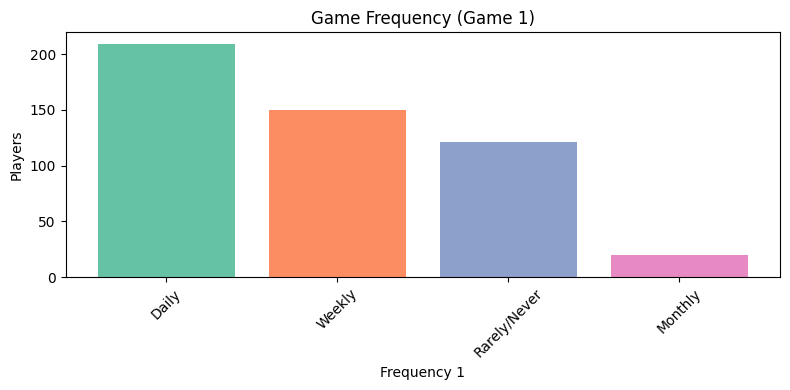

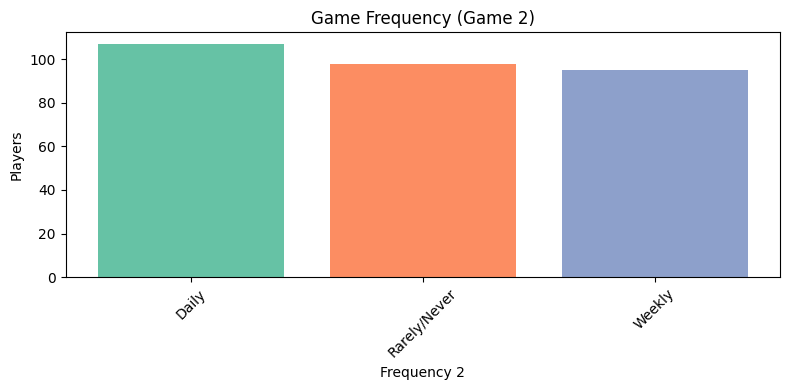

In [71]:
# Gráficas
graficar_columna_categorica(df_final, 'frequency_1', 'Game Frequency (Game 1)')
graficar_columna_categorica(df_final, 'frequency_2', 'Game Frequency (Game 2)')


In [72]:
# Media de horas jugadas por frecuencia para el juego nº1
df_final.groupby("frequency_1")["hours_per_week_1"].value_counts().sort_index()

frequency_1   hours_per_week_1  
Daily         10–20 hours           68
              1–5 hours             37
              5–10 hours            67
              More than 20 hours    37
Monthly       10–20 hours            4
              1–5 hours              6
              5–10 hours             2
              Less than 1 hour       6
              More than 20 hours     2
Rarely/Never  0 hours                6
              10–20 hours           25
              1–5 hours             26
              5–10 hours            36
              More than 20 hours    28
Weekly        10–20 hours           38
              1–5 hours             43
              5–10 hours            56
              More than 20 hours    13
Name: count, dtype: int64

In [73]:
# Media de horas jugadas por frecuencia para el juego nº2
df_final.groupby("frequency_2")["hours_per_week_2"].value_counts().sort_index()

frequency_2   hours_per_week_2  
Daily         10–20 hours           24
              1–5 hours             27
              5–10 hours            29
              More than 20 hours    27
Rarely/Never  10–20 hours           27
              1–5 hours             22
              5–10 hours            21
              More than 20 hours    28
Weekly        10–20 hours           21
              1–5 hours             31
              5–10 hours            20
              More than 20 hours    23
Name: count, dtype: int64

## 1.2. Comparativa por dispositivo – Horas semanales jugadas

In [74]:
# Horas por semana de juego nº1
df_final['hours_per_week_1'].value_counts(dropna=False)

hours_per_week_1
5–10 hours            161
10–20 hours           135
1–5 hours             112
More than 20 hours     80
0 hours                 6
Less than 1 hour        6
Name: count, dtype: int64

In [75]:
# Horas por semana de juego nº2
df_final['hours_per_week_2'].value_counts(dropna=False)

hours_per_week_2
nan                   200
1–5 hours              80
More than 20 hours     78
10–20 hours            72
5–10 hours             70
Name: count, dtype: int64

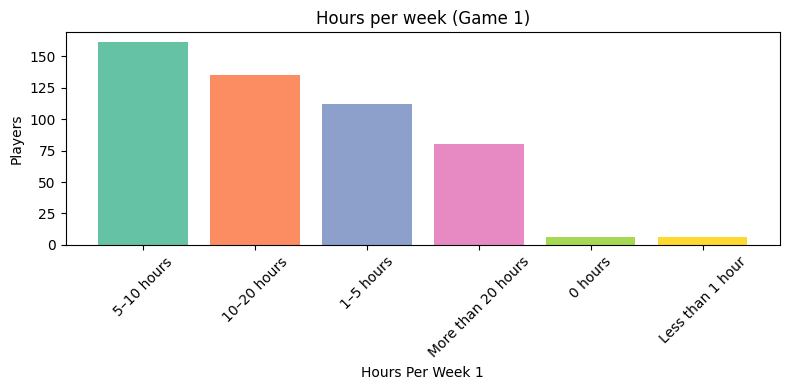

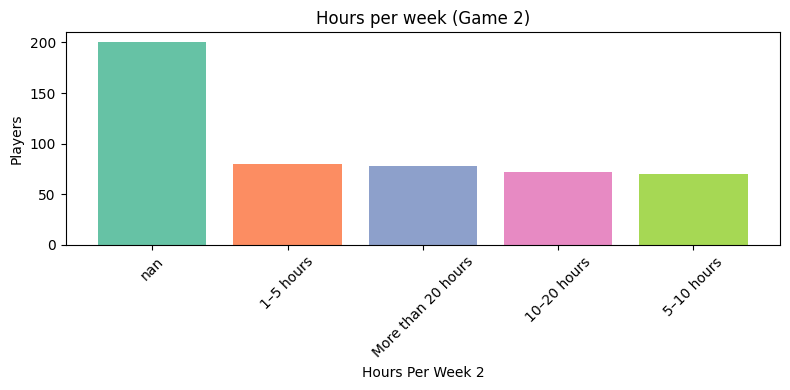

In [76]:
# Gráfico
graficar_columna_categorica(df_final, 'hours_per_week_1', 'Hours per week (Game 1)')
graficar_columna_categorica(df_final, 'hours_per_week_2', 'Hours per week (Game 2)')

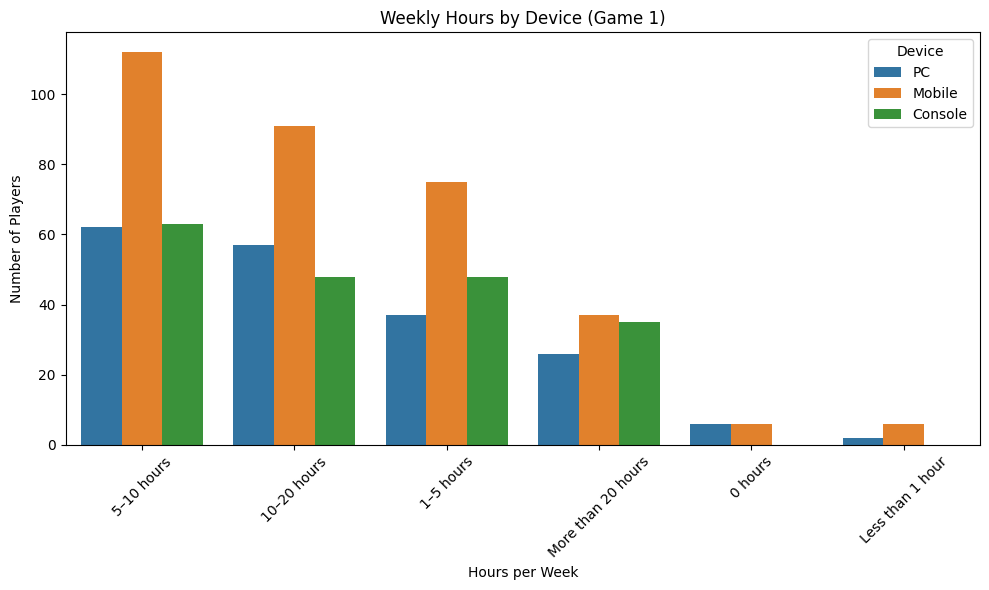

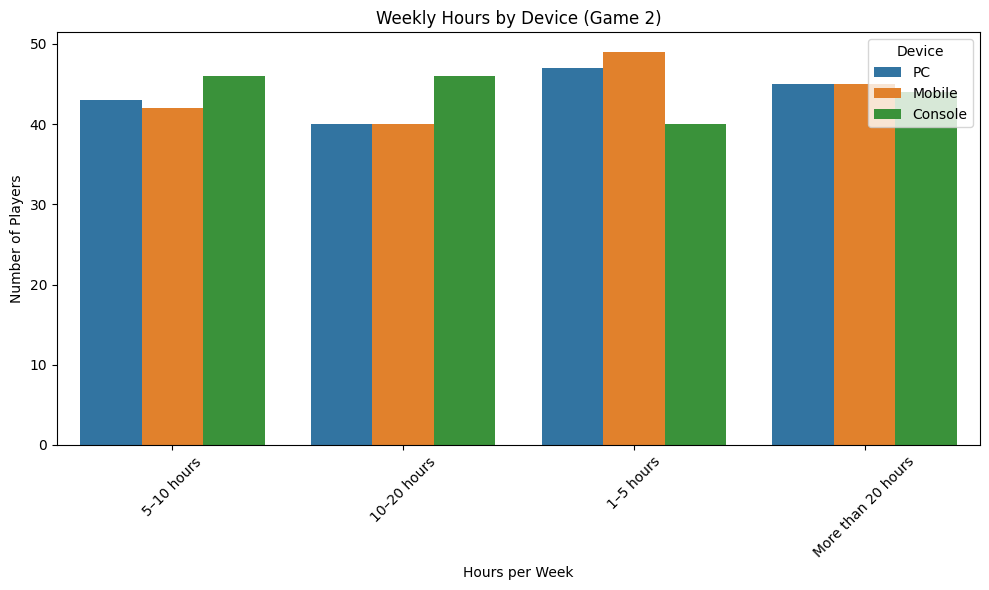

In [77]:
# Comparativa Dispositivos y horas por semana
# Datos para Game 1
game1_data = {
    "Device": ["PC", "PC", "PC", "PC", "PC", "PC",
               "Mobile", "Mobile", "Mobile", "Mobile", "Mobile", "Mobile",
               "Console", "Console", "Console", "Console", "Console", "Console"],
    "Hours": ["5–10 hours", "10–20 hours", "1–5 hours", "More than 20 hours", "0 hours", "Less than 1 hour"] * 3,
    "Players": [62, 57, 37, 26, 6, 2,
                112, 91, 75, 37, 6, 6,
                63, 48, 48, 35, 0, 0]
}

df_game1 = pd.DataFrame(game1_data)

# Datos para Game 2
game2_data = {
    "Device": ["PC", "PC", "PC", "PC",
               "Mobile", "Mobile", "Mobile", "Mobile",
               "Console", "Console", "Console", "Console"],
    "Hours": ["5–10 hours", "10–20 hours", "1–5 hours", "More than 20 hours"] * 3,
    "Players": [43, 40, 47, 45,
                42, 40, 49, 45,
                46, 46, 40, 44]
}

df_game2 = pd.DataFrame(game2_data)

# Gráfico Game 1
plt.figure(figsize=(10, 6))
sns.barplot(data=df_game1, x="Hours", y="Players", hue="Device")
plt.title("Weekly Hours by Device (Game 1)")
plt.xlabel("Hours per Week")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico Game 2
plt.figure(figsize=(10, 6))
sns.barplot(data=df_game2, x="Hours", y="Players", hue="Device")
plt.title("Weekly Hours by Device (Game 2)")
plt.xlabel("Hours per Week")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.3. Juegos favoritos según horas jugadas por semana

In [78]:
# Limpiar espacios en los valores
df_final["hours_per_week_1"] = df_final["hours_per_week_1"].str.strip()

# Volver a aplicar el filtro
horas_activas = ["10-20 hours", "More than 20 hours"]
jugadores_activos = df_final[df_final["hours_per_week_1"].isin(horas_activas)]


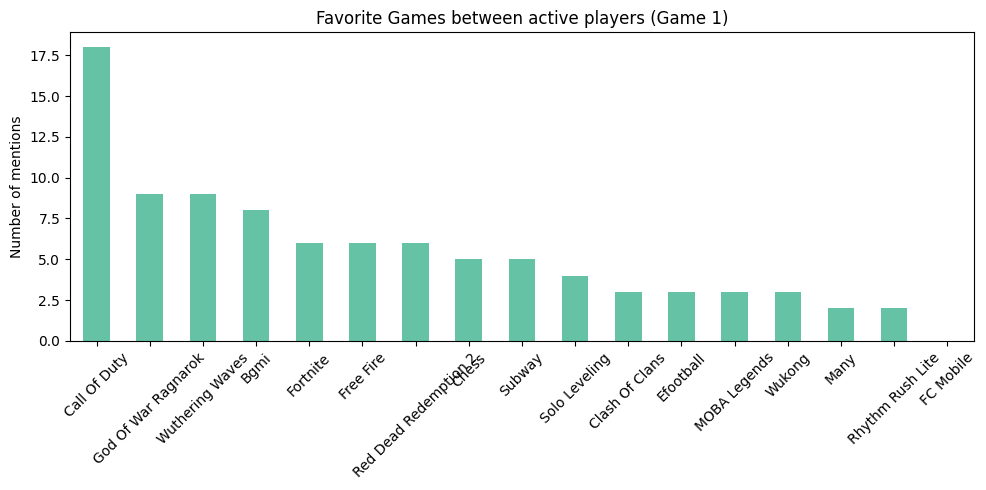

In [79]:
# Game 1
# 1. Definir qué categorías indican jugadores activos
horas_activas = ["10-20 hours", "More than 20 hours"]

# 2. Filtrar DataFrame para quedarnos solo con jugadores más activos
jugadores_activos = df_final[df_final["hours_per_week_1"].isin(horas_activas)]

# 3. Seleccionar columnas de juegos favoritos (Game 1)
cols_juegos = [col for col in df_final.columns if col.startswith("favorite_game1_")]

# 4. Contar cuántos jugadores activos mencionan cada juego
juegos_frecuentes = jugadores_activos[cols_juegos].sum().sort_values(ascending=False)

# 5. Limpiar nombres de columnas
juegos_frecuentes.index = juegos_frecuentes.index.str.replace("favorite_game1_", "")

# 6. Graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
juegos_frecuentes.plot(kind="bar", color="#66c2a5")
plt.title("Favorite Games between active players (Game 1)")
plt.ylabel("Number of mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

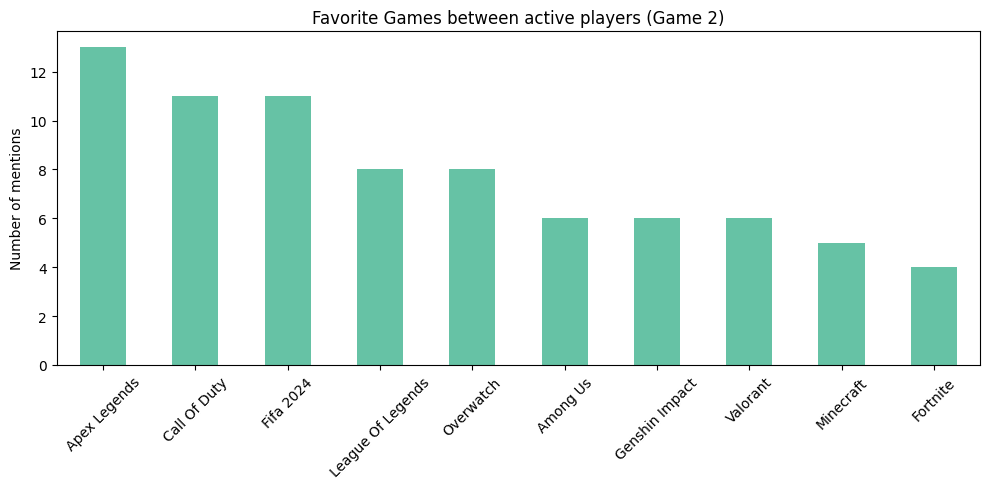

In [80]:
# Game 2
# 1. Definir qué categorías indican jugadores activos
horas_activas = ["10-20 hours", "More than 20 hours"]

# 2. Filtrar DataFrame para quedarnos solo con jugadores más activos
jugadores_activos = df_final[df_final["hours_per_week_2"].isin(horas_activas)]

# 3. Seleccionar columnas de juegos favoritos (Game 2)
cols_juegos = [col for col in df_final.columns if col.startswith("favorite_game2_")]

# 4. Contar cuántos jugadores activos mencionan cada juego
juegos_frecuentes = jugadores_activos[cols_juegos].sum().sort_values(ascending=False)

# 5. Limpiar nombres de columnas
juegos_frecuentes.index = juegos_frecuentes.index.str.replace("favorite_game2_", "")

# 6. Graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
juegos_frecuentes.plot(kind="bar", color="#66c2a5")
plt.title("Favorite Games between active players (Game 2)")
plt.ylabel("Number of mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.4. Motivaciones principales según horas jugadas por semana

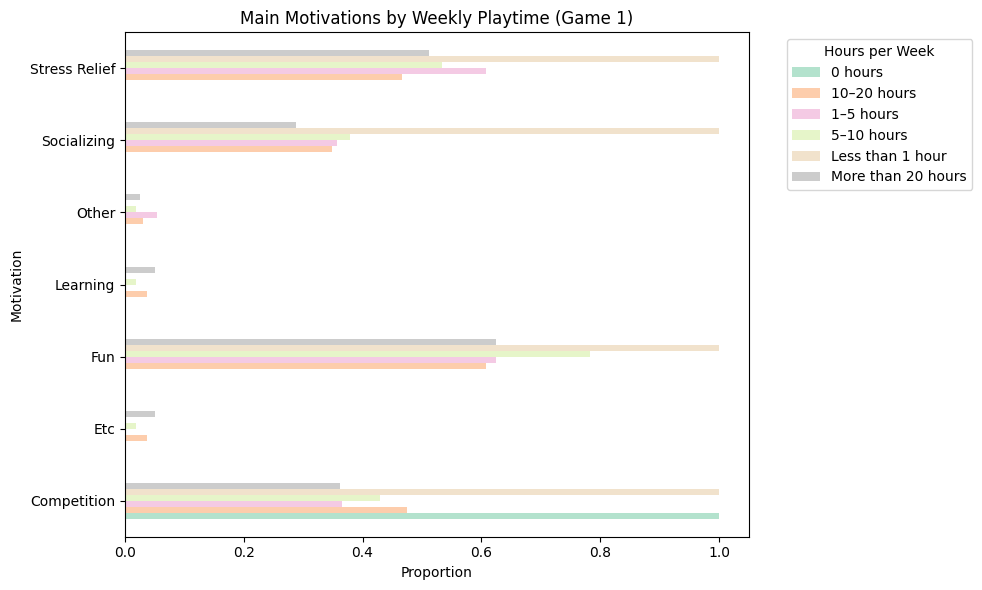

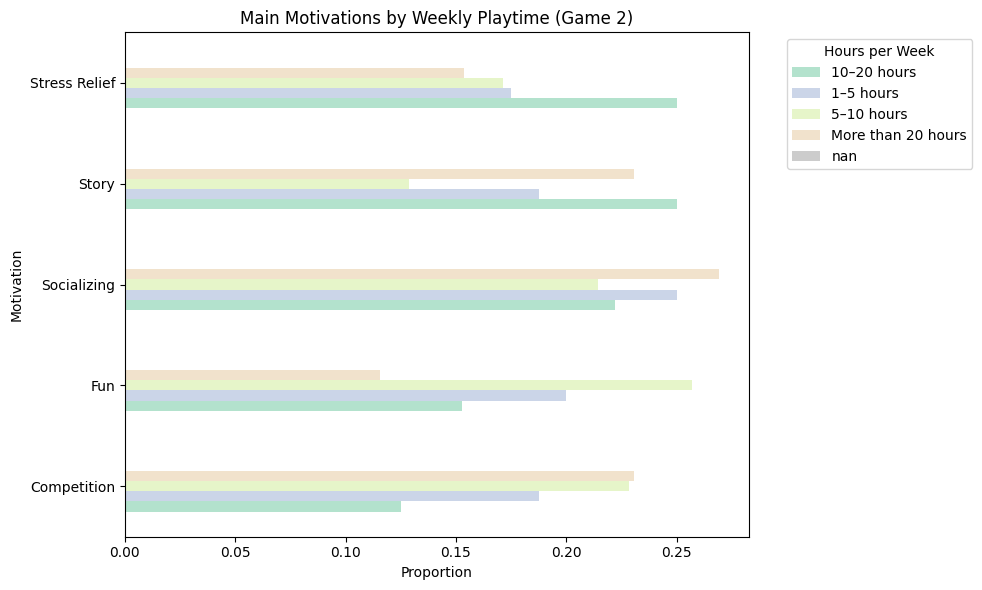

In [81]:
# Horas por semana vs motivaciones principales (Juego 1)
# Añadimos columna de horas
df_mot_hours = df_final[["hours_per_week_1"] + list(df_final.filter(like="motivation1_").columns)]

# Agrupamos por horas
motivation_by_hours = df_mot_hours.groupby("hours_per_week_1").mean()

# Limpiamos nombres de motivaciones
motivation_by_hours.columns = motivation_by_hours.columns.str.replace("motivation1_", "")

# Gráfico
motivation_by_hours.T.plot(kind="barh", figsize=(10, 6), colormap="Pastel2")
plt.title("Main Motivations by Weekly Playtime (Game 1)")
plt.xlabel("Proportion")
plt.ylabel("Motivation")
plt.legend(title="Hours per Week", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Horas por semana vs motivaciones principales (Juego 2)
# Añadimos columna de horas
df_mot_hours = df_final[["hours_per_week_2"] + list(df_final.filter(like="motivation2_").columns)]

# Agrupamos por horas
motivation_by_hours2 = df_mot_hours.groupby("hours_per_week_2").mean()

# Limpiamos nombres de motivaciones
motivation_by_hours2.columns = motivation_by_hours2.columns.str.replace("motivation2_", "")

# Gráfico
motivation_by_hours2.T.plot(kind="barh", figsize=(10, 6), colormap="Pastel2")
plt.title("Main Motivations by Weekly Playtime (Game 2)")
plt.xlabel("Proportion")
plt.ylabel("Motivation")
plt.legend(title="Hours per Week", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 1.4.  Motivaciones según modo de juego

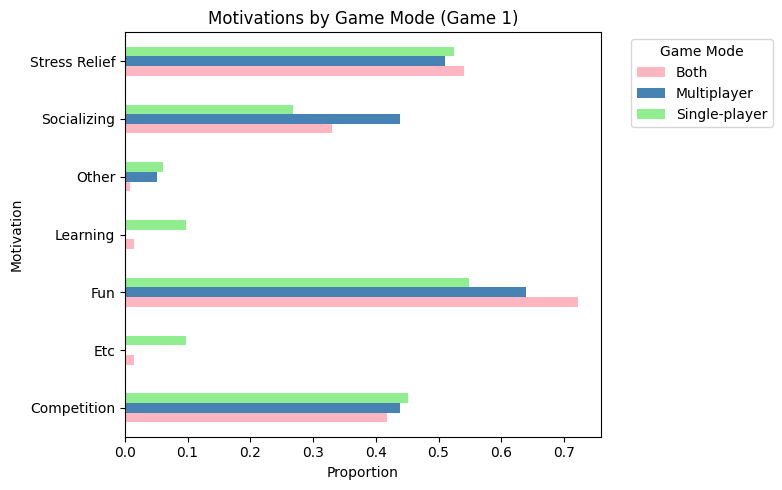

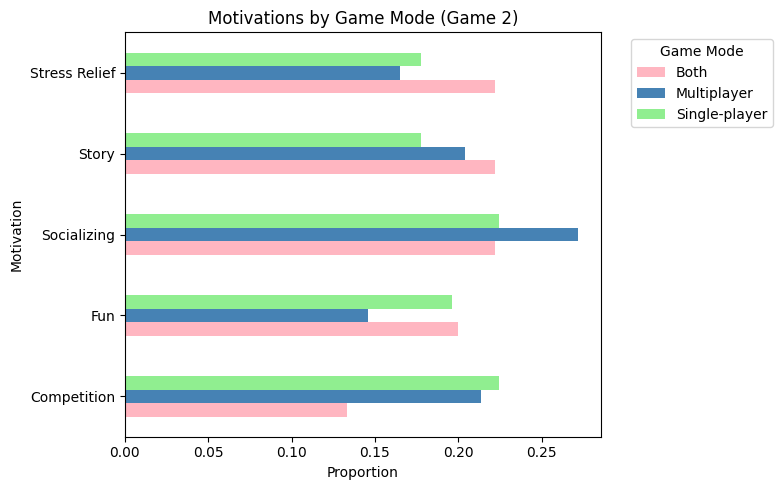

In [82]:
# Modo de juego vs Motivations (Juego 1)
# Extraemos columnas necesarias
df_game_mode = df_final.filter(like="game_mode1_").copy()
df_game_mode["motivation"] = df_final.filter(like="motivation1_").values.tolist()

# Para cada modo de juego, calculamos la media de cada motivación
mot_cols = df_final.filter(like="motivation1_").columns
game_mode_labels = df_final.filter(like="game_mode1_").columns

# Creamos un nuevo DataFrame para almacenar resultados
motivation_by_mode = {}

for mode in game_mode_labels:
    subset = df_final[df_final[mode] == 1]
    motivation_by_mode[mode.replace("game_mode1_", "")] = subset[mot_cols].mean()

# Convertimos a DataFrame y limpiamos nombres
motivation_by_mode_df = pd.DataFrame(motivation_by_mode)
motivation_by_mode_df.index = motivation_by_mode_df.index.str.replace("motivation1_", "")

# Gráfico
motivation_by_mode_df.plot(
    kind="barh",
    figsize=(8, 5),
    color=["#FFB6C1", "#4682B4", "#90EE90", "#D8BFD8", "#98FB98", "#F0E68C", "#FFDAB9"]
)
plt.title("Motivations by Game Mode (Game 1)")
plt.xlabel("Proportion")
plt.ylabel("Motivation")
plt.legend(title="Game Mode", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Modo de juego vs Motivaciones (Juego 2)
# 1. Extraemos columnas necesarias
df_game_mode2 = df_final.filter(like="game_mode2_").copy()
df_game_mode2["motivation"] = df_final.filter(like="motivation2_").values.tolist()

# 2. Identificamos columnas de motivación y etiquetas de modo de juego
mot_cols2 = df_final.filter(like="motivation2_").columns
game_mode_labels2 = df_final.filter(like="game_mode2_").columns

# 3. Creamos un nuevo diccionario para guardar resultados
motivation_by_mode2 = {}

# 4. Calculamos medias de motivación para cada modo de juego
for mode in game_mode_labels2:
    subset = df_final[df_final[mode] == 1]
    motivation_by_mode2[mode.replace("game_mode2_", "")] = subset[mot_cols2].mean()

# 5. Convertimos a DataFrame y limpiamos índices
motivation_by_mode2_df = pd.DataFrame(motivation_by_mode2)
motivation_by_mode2_df.index = motivation_by_mode2_df.index.str.replace("motivation2_", "")

# 6. Gráfico
motivation_by_mode2_df.plot(
    kind="barh",
    figsize=(8, 5),
    color=["#FFB6C1", "#4682B4", "#90EE90", "#D8BFD8", "#98FB98", "#F0E68C", "#FFDAB9"]
)
plt.title("Motivations by Game Mode (Game 2)")
plt.xlabel("Proportion")
plt.ylabel("Motivation")
plt.legend(title="Game Mode", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 📈 1.5. Correlaciones binarias (Game 1 y Game 2)

#### Heatmap de correlación

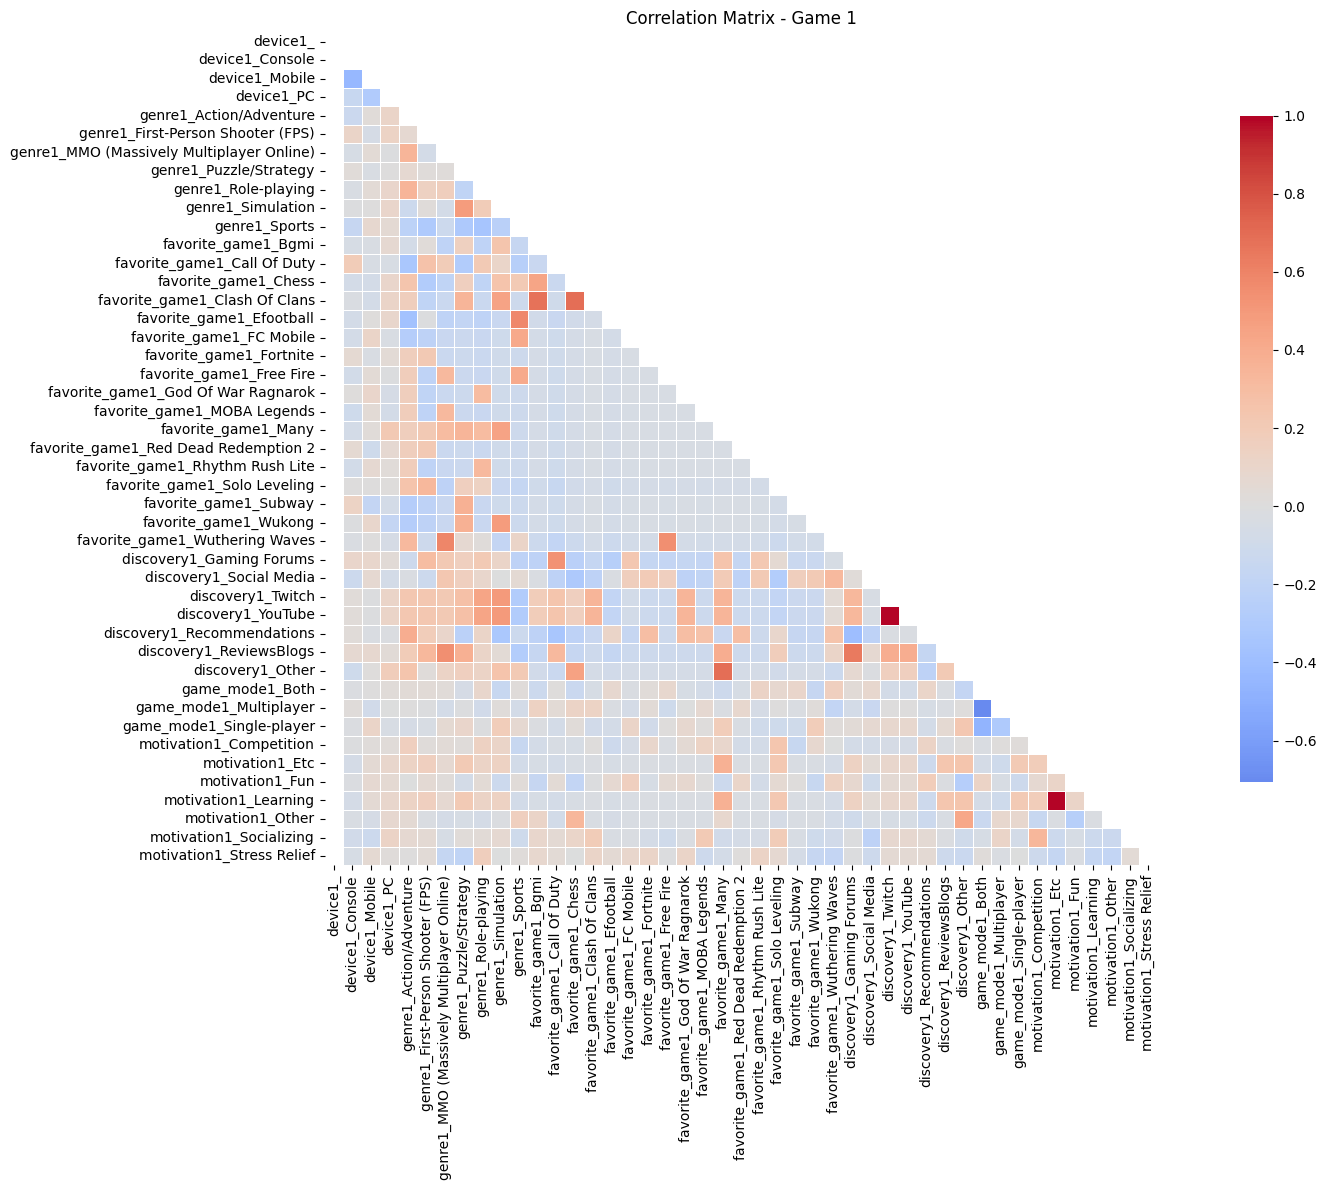

In [83]:
# Paso 1: Seleccionar columnas binarias del juego 1
binary_cols_j1 = [
    col for col in df_final.columns 
    if '1_' in col and df_final[col].dropna().isin([0, 1]).all()
]

# Paso 2: Crear sub-dataframe
df_j1 = df_final[binary_cols_j1]

# Paso 3: Crear matriz de correlaciones
corr_matrix_j1 = df_j1.corr()

# Paso 4: Máscara para mitad superior
mask = np.triu(np.ones_like(corr_matrix_j1, dtype=bool))

# Paso 5: Visualización
plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix_j1, 
    mask=mask, 
    cmap="coolwarm", 
    center=0, 
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix - Game 1")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



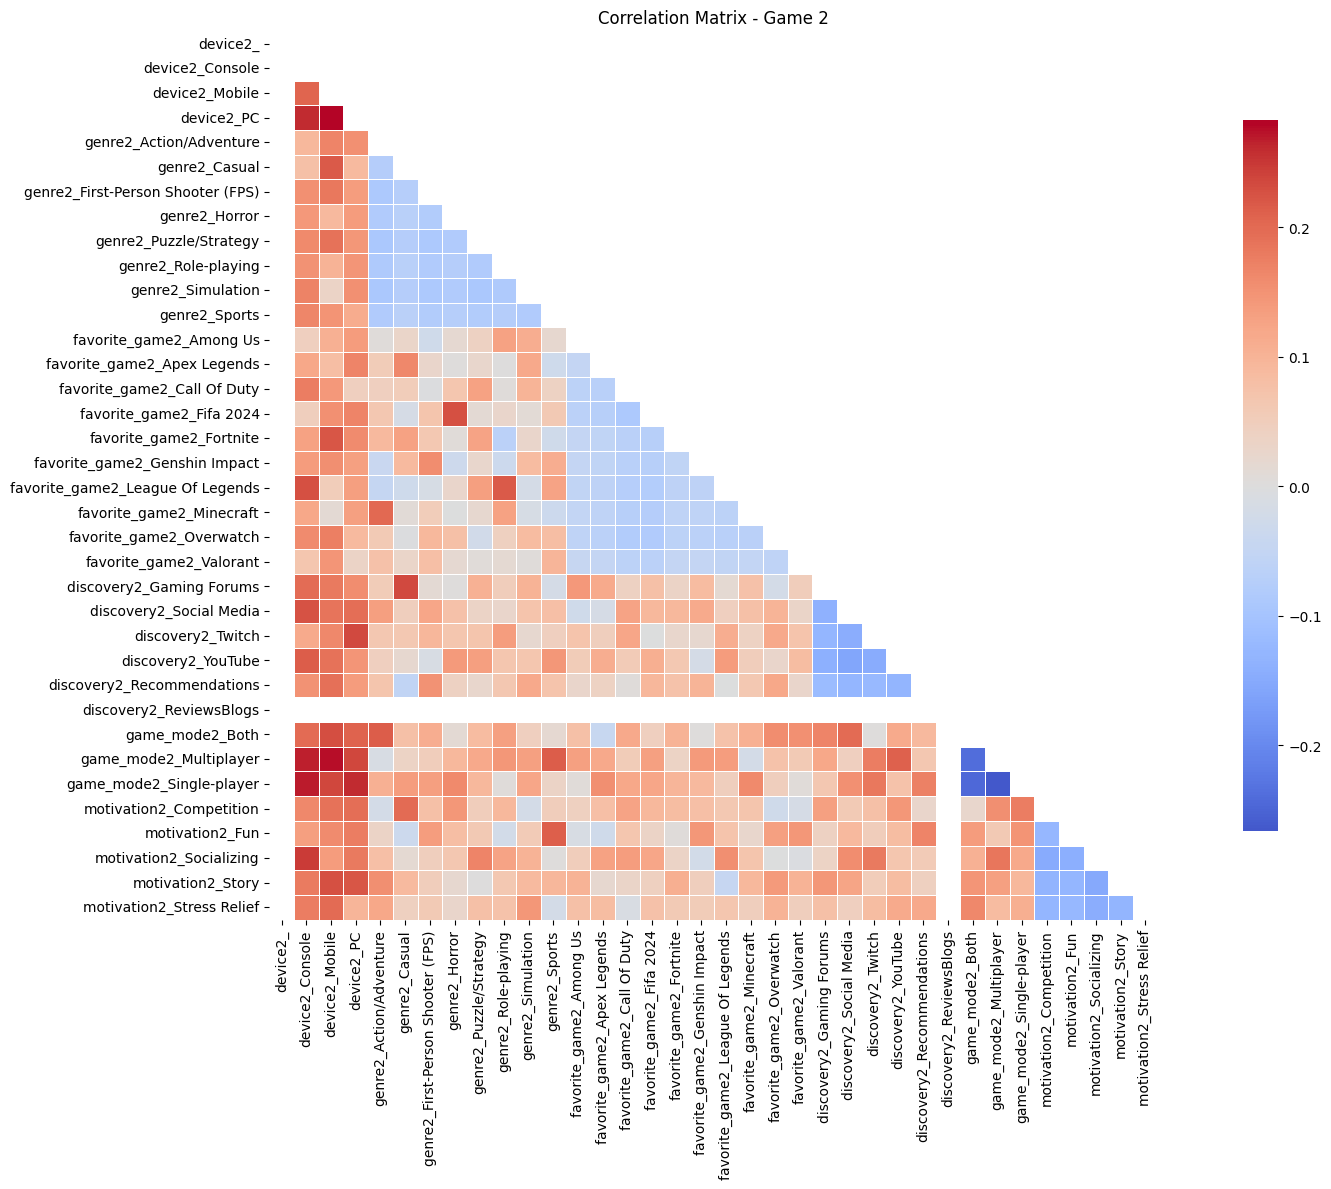

In [84]:
# Paso 1: Seleccionar columnas binarias del juego 2
binary_cols_j2 = [
    col for col in df_final.columns 
    if '2_' in col and df_final[col].dropna().isin([0, 1]).all()
]

# Paso 2: Crear sub-dataframe
df_j2 = df_final[binary_cols_j2]

# Paso 3: Crear matriz de correlaciones
corr_matrix_j2 = df_j2.corr()

# Paso 4: Máscara para mitad superior
mask = np.triu(np.ones_like(corr_matrix_j2, dtype=bool))

# Paso 5: Visualización
plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix_j2, 
    mask=mask, 
    cmap="coolwarm", 
    center=0, 
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix - Game 2")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Pregunta 2: ¿Hay diferencias claras según género o edad?
## 2.1. Distribución por edad

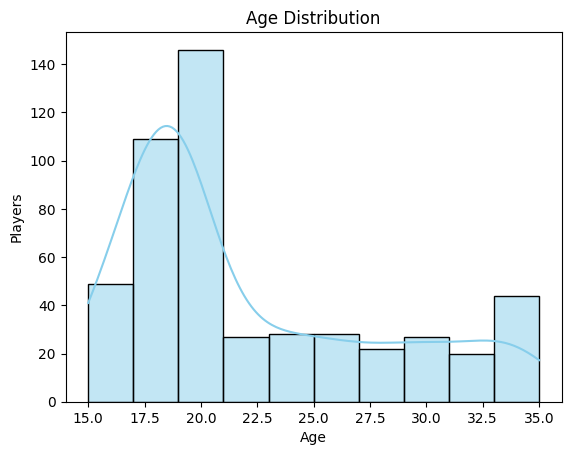

In [85]:
sns.histplot(df_final['age'], bins=10, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Players')
plt.show()

## 2.2. Edad por género

In [86]:
# Género
df_final['gender'].value_counts(dropna=False)


gender
Female    268
Male      232
Name: count, dtype: int64

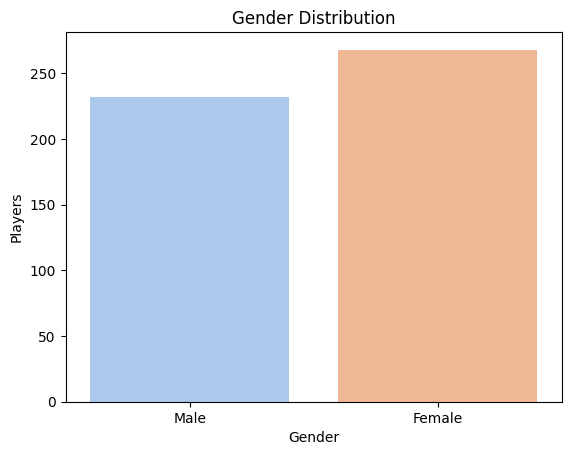

In [87]:
sns.countplot(x='gender', hue='gender', data=df_final, palette='pastel')
plt.title('Gender Distribution')
plt.ylabel('Players')
plt.xlabel('Gender')
plt.show()

#### Conclusión: Hay más mujeres que hombres en los datos

In [88]:
# Edad
df_final['age'].describe()

count    500.000000
mean      21.948000
std        5.682771
min       15.000000
25%       18.000000
50%       19.000000
75%       26.000000
max       35.000000
Name: age, dtype: float64

In [89]:
# Edad media según género
df_final.groupby("gender")["age"].mean()

gender
Female    21.384328
Male      22.599138
Name: age, dtype: float64

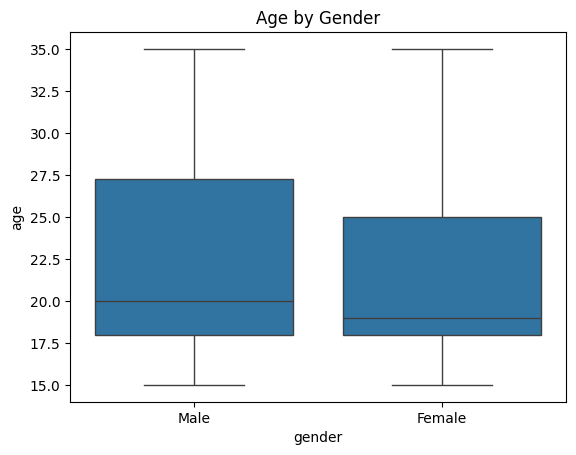

In [90]:
# Boxplot de edad según género
sns.boxplot(x="gender", y="age", data=df_final)
plt.title("Age by Gender")
plt.show()

In [91]:
# Separar las edades por género
edades_m = df_final[df_final['gender'] == 'Male']['age']
edades_f = df_final[df_final['gender'] == 'Female']['age']

# Test de Mann-Whitney
stat, p = mannwhitneyu(edades_m, edades_f, alternative='two-sided')

print(f'Estadístico U: {stat:.2f}, p-valor: {p:.4f}')


Estadístico U: 35126.00, p-valor: 0.0116


## 2.3. Motivaciones por género

In [92]:
# Motivación juego nº1
df_final.filter(like='motivation1_').sum().sort_values(ascending=False)

motivation1_Fun              334
motivation1_Stress Relief    264
motivation1_Competition      215
motivation1_Socializing      177
motivation1_Other             15
motivation1_Etc               12
motivation1_Learning          12
dtype: int64

In [93]:
# Motivación juego nº2
df_final.filter(like='motivation2_').sum().sort_values(ascending=False)

motivation2_Socializing      72
motivation2_Story            60
motivation2_Competition      58
motivation2_Stress Relief    56
motivation2_Fun              54
dtype: int64

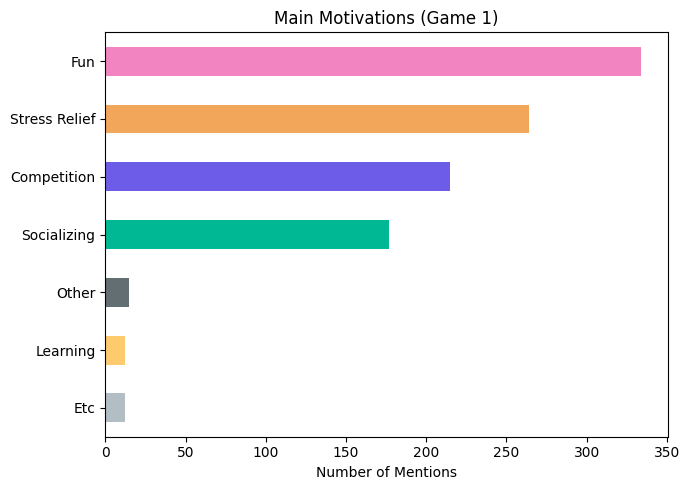

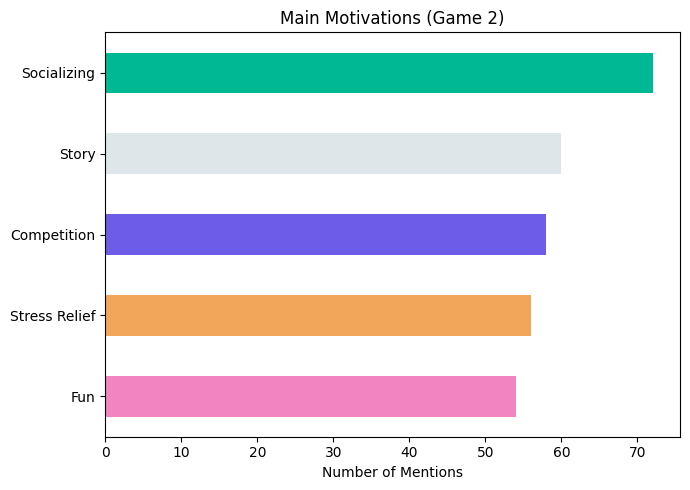

In [94]:
# Diccionario de colores por motivación
color_motivaciones = {
    'Fun': '#f285c1',
    'Stress Relief': '#f2a65a',
    'Competition': '#6c5ce7',
    'Socializing': '#00b894',
    'Learning': '#fdcb6e',
    'Other': '#636e72',
    'Etc': '#b2bec3'
}

# --- GAME 1 ---
data1 = df_final.filter(like='motivation1_').sum()
data1.index = data1.index.str.replace('motivation1_', '')
data1 = data1.sort_values()
colores1 = [color_motivaciones.get(m, '#dfe6e9') for m in data1.index]

data1.plot(kind='barh', figsize=(7, 5), color=colores1)
plt.title('Main Motivations (Game 1)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()

# --- GAME 2 ---
data2 = df_final.filter(like='motivation2_').sum()
data2.index = data2.index.str.replace('motivation2_', '')
data2 = data2.sort_values()
colores2 = [color_motivaciones.get(m, '#dfe6e9') for m in data2.index]

data2.plot(kind='barh', figsize=(7, 5), color=colores2)
plt.title('Main Motivations (Game 2)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()



In [95]:
# Porcentaje de jugadores por motivación y género para el juego nº1
df_final.groupby("gender")[df_final.filter(like="motivation1_").columns].mean() * 100


,motivation1_Competition,motivation1_Etc,motivation1_Fun,motivation1_Learning,motivation1_Other,motivation1_Socializing,motivation1_Stress Relief
gender,,,,,,,
Female,43.283582,2.238806,66.791045,2.238806,2.238806,35.447761,55.970149
Male,42.672414,2.586207,66.810345,2.586207,3.879310,35.344828,49.137931


In [96]:
# Porcentaje de jugadores por motivación y género para el juego nº2
df_final.groupby("gender")[df_final.filter(like="motivation2_").columns].mean() * 100

,motivation2_Competition,motivation2_Fun,motivation2_Socializing,motivation2_Story,motivation2_Stress Relief
gender,,,,,
Female,12.313433,11.567164,11.194030,8.208955,10.820896
Male,10.775862,9.913793,18.103448,16.379310,11.637931


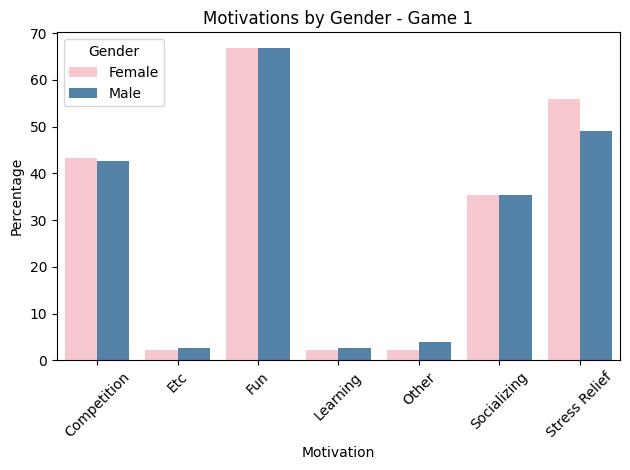

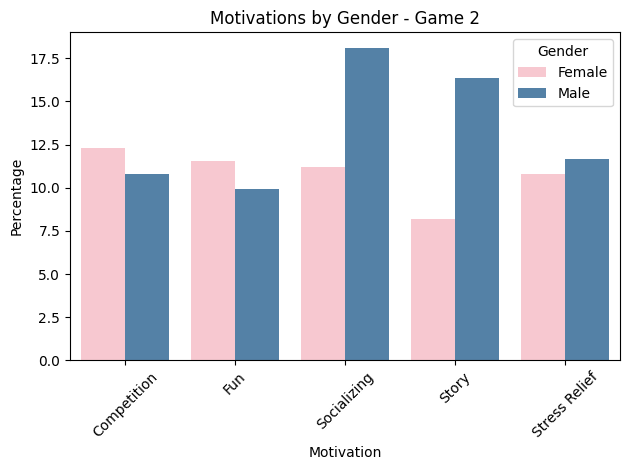

In [97]:
# Motivaciones por género - Game 1
df_mot_gen_1 = df_final.filter(like="motivation1_").copy()
df_mot_gen_1["Gender"] = df_final["gender"].copy()

df_mot_gen_1 = df_mot_gen_1.dropna(subset=["Gender"])
df_mot_gen_1 = df_mot_gen_1[df_mot_gen_1["Gender"].isin(["Female", "Male"])]
df_mot_gen_1["Gender"] = df_mot_gen_1["Gender"].astype(str)

df_plot_1 = df_mot_gen_1.groupby("Gender").mean().T.reset_index()
df_plot_1.iloc[:, 1:] *= 100
df_plot_1["Motivation"] = df_plot_1["index"].str.replace("motivation1_", "")
df_plot_1 = df_plot_1.drop(columns=["index"])  

df_plot_1_melted = df_plot_1.melt(id_vars="Motivation", var_name="Gender", value_name="Percentage")
df_plot_1_melted = df_plot_1_melted[df_plot_1_melted["Gender"].isin(["Female", "Male"])]

sns.barplot(
    data=df_plot_1_melted,
    x="Motivation",
    y="Percentage",
    hue="Gender",
    palette={"Female": "pink", "Male": "steelblue"}
)

plt.title("Motivations by Gender - Game 1")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1. Filtrar motivaciones y género
df_mot_gen_2 = df_final.filter(like="motivation2_").copy()
df_mot_gen_2["Gender"] = df_final["gender"].copy()

# 2. Eliminar nulos y asegurar categorías válidas
df_mot_gen_2 = df_mot_gen_2.dropna(subset=["Gender"])
df_mot_gen_2 = df_mot_gen_2[df_mot_gen_2["Gender"].isin(["Female", "Male"])]
df_mot_gen_2["Gender"] = df_mot_gen_2["Gender"].astype(str)

# 3. Calcular medias y convertir a porcentaje
df_plot_2 = df_mot_gen_2.groupby("Gender").mean().T.reset_index()
df_plot_2.iloc[:, 1:] *= 100
df_plot_2["Motivation"] = df_plot_2["index"].str.replace("motivation2_", "")
df_plot_2 = df_plot_2.drop(columns=["index"])

# 4. Convertir a formato largo
df_plot_2_melted = df_plot_2.melt(id_vars="Motivation", var_name="Gender", value_name="Percentage")
df_plot_2_melted = df_plot_2_melted[df_plot_2_melted["Gender"].isin(["Female", "Male"])]

# 5. Graficar
sns.barplot(
    data=df_plot_2_melted,
    x="Motivation",
    y="Percentage",
    hue="Gender",
    palette={"Female": "pink", "Male": "steelblue"}
)

plt.title("Motivations by Gender - Game 2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




## 2.4. Motivaciones por rango de edad

In [98]:
bins = [10, 15, 20, 25, 30, 35, 40, 100]
labels = ['10-15', '16-20', '21-25', '26-30', '31-35', '36-40', '40+']

df_final['age_group'] = pd.cut(df_final['age'], bins=bins, labels=labels)

C:\Users\sanlo\AppData\Local\Temp\ipykernel_1728\875903427.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  motivation_by_age = df_final.groupby('age_group')[motivation_cols].mean()


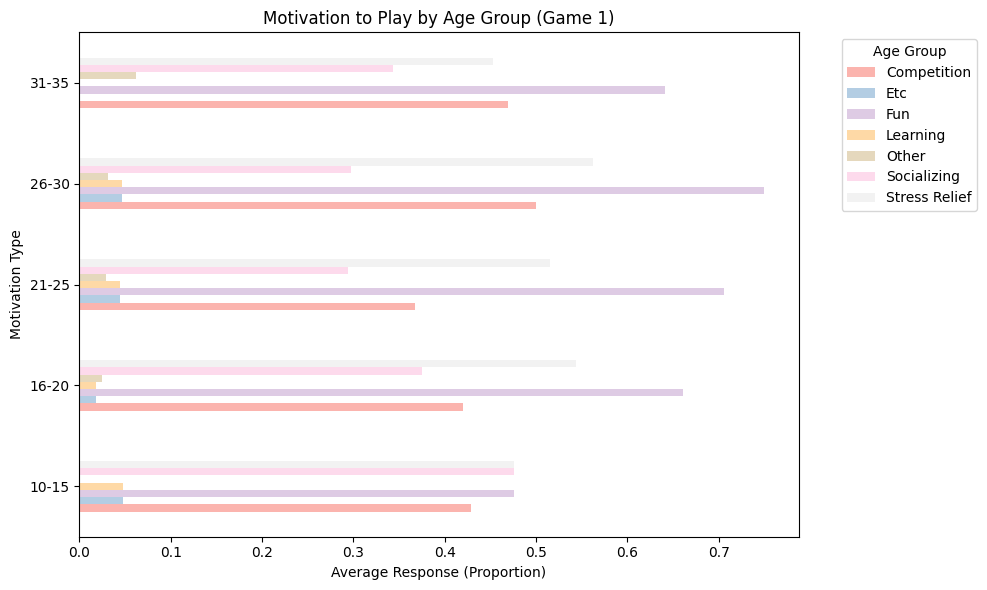

C:\Users\sanlo\AppData\Local\Temp\ipykernel_1728\875903427.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  motivation_by_age2 = df_final.groupby('age_group')[motivation_cols2].mean()


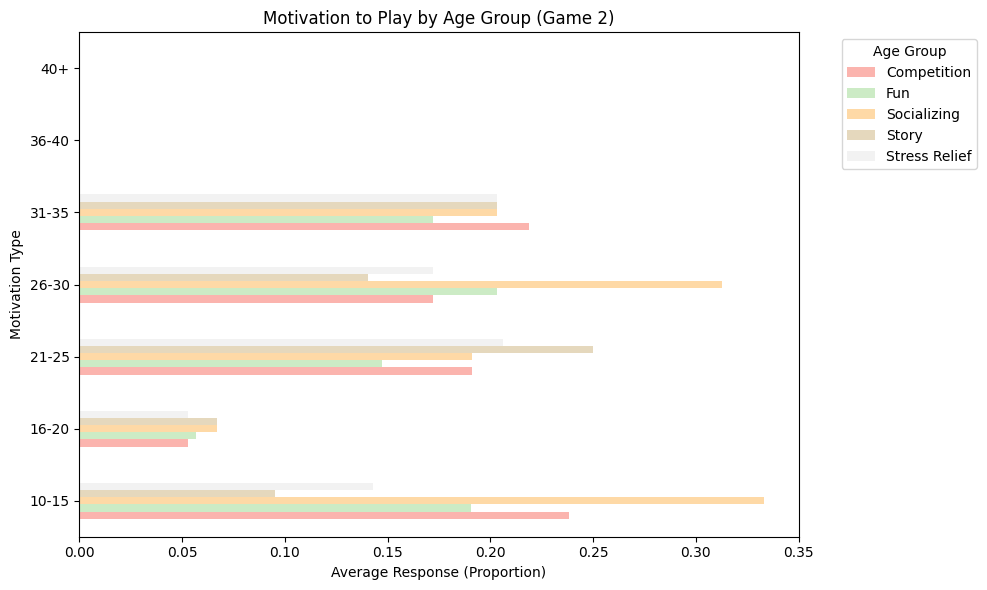

In [99]:
# Juego 1
# Filtrar solo columnas de motivación del juego 1
motivation_cols = df_final.filter(like='motivation1_').columns

# Asegurar que 'age_group' es categoría (por si se ha perdido)
df_final['age_group'] = df_final['age_group'].astype('category')

# Agrupar por grupo de edad y calcular la media de cada motivación
motivation_by_age = df_final.groupby('age_group')[motivation_cols].mean()

# Eliminamos grupos de edad con todos los valores NaN (sin datos)
motivation_by_age = motivation_by_age.dropna(how='all')

# Limpiar nombres de columnas (quitar 'motivation1_')
motivation_by_age.columns = motivation_by_age.columns.str.replace('motivation1_', '')

# Visualización
motivation_by_age.plot(kind='barh', figsize=(10, 6), colormap='Pastel1')
plt.title("Motivation to Play by Age Group (Game 1)")
plt.xlabel("Average Response (Proportion)")
plt.ylabel("Motivation Type")
plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Juego 2
# Filtrar solo columnas de motivación principal
motivation_cols2 = df_final.filter(like='motivation2_').columns

# Agrupar por grupo de edad y calcular la media de cada motivación
motivation_by_age2 = df_final.groupby('age_group')[motivation_cols2].mean()

# Eliminar el prefijo para que las etiquetas sean más limpias
motivation_by_age2.columns = motivation_by_age2.columns.str.replace('motivation2_', '')

# Visualización
motivation_by_age2.plot(kind='barh', figsize=(10, 6), colormap='Pastel1')
plt.title("Motivation to Play by Age Group (Game 2)")
plt.xlabel("Average Response (Proportion)")
plt.ylabel("Motivation Type")
plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



## 2.5. Dispositivo más usado por género

In [100]:
# Dispositivos juego nº1
df_final.filter(like='device1_').sum().sort_values(ascending=False)


device1_           500
device1_Mobile     340
device1_PC         194
device1_Console    184
dtype: int64

In [101]:
# Dispositivos juego nº2
df_final.filter(like='device2_').sum().sort_values(ascending=False)

device2_           500
device2_Mobile     177
device2_Console    176
device2_PC         167
dtype: int64

In [102]:
# Géneros juego nº1
df_final.filter(like='genre1_').sum().sort_values(ascending=False)

genre1_Action/Adventure                      298
genre1_First-Person Shooter (FPS)            238
genre1_MMO (Massively Multiplayer Online)    153
genre1_Role-playing                          153
genre1_Puzzle/Strategy                       130
genre1_Sports                                108
genre1_Simulation                             86
dtype: int64

In [103]:
# Géneros juego nº2
df_final.filter(like='genre2_').sum().sort_values(ascending=False)

genre2_Action/Adventure              42
genre2_Simulation                    42
genre2_Puzzle/Strategy               41
genre2_First-Person Shooter (FPS)    40
genre2_Role-playing                  36
genre2_Horror                        35
genre2_Sports                        34
genre2_Casual                        30
dtype: int64

In [104]:
color_generos = {
    'Action/Adventure': '#66c2a5',
    'First-Person Shooter (FPS)': '#fc8d62',
    'Role-playing': '#8da0cb',
    'MMO (Massively Multiplayer Online)': '#e78ac3',
    'Puzzle/Strategy': '#a6d854',
    'Sports': '#ffd92f',
    'Simulation': '#e5c494',
    'Horror': '#cab2d6',
    'Casual': '#fdbf6f'
}

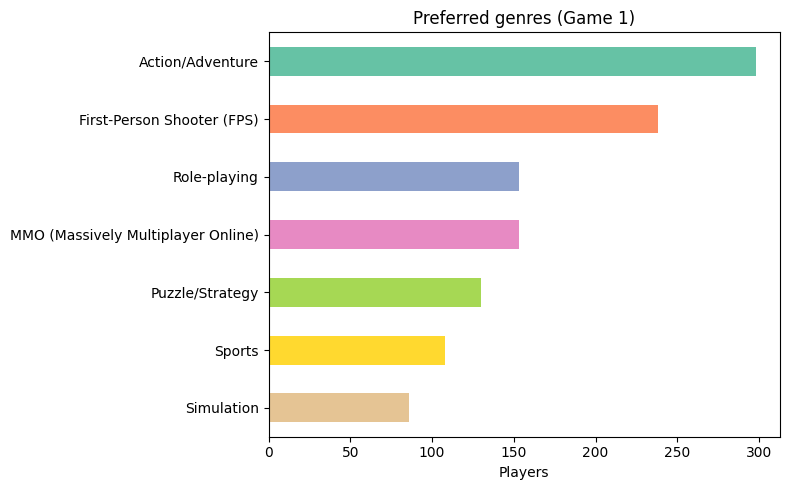

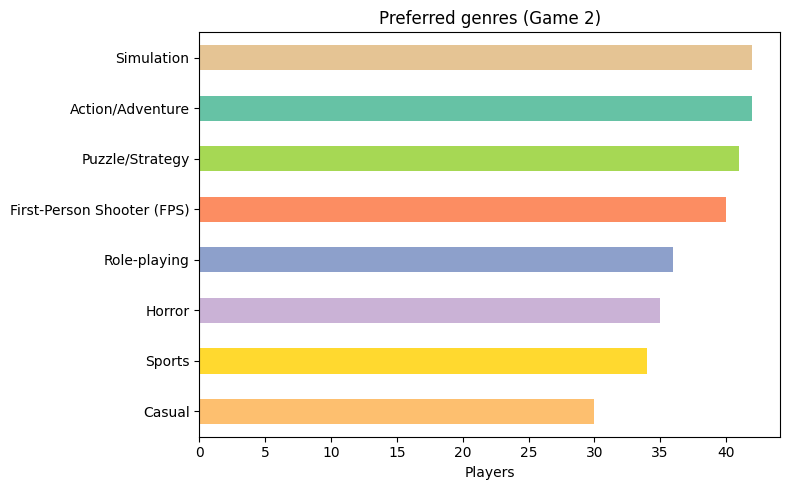

In [105]:
# Game 1
data = df_final.filter(like='genre1_').sum()
data.index = data.index.str.replace('genre1_', '', regex=False)
data = data.sort_values()

colors_genres = [color_generos[genre] for genre in data.index]

data.plot(kind='barh', figsize=(8, 5), color=colors_genres)
plt.title('Preferred genres (Game 1)')
plt.xlabel('Players')
plt.tight_layout()
plt.show()

# Game 2
data = df_final.filter(like='genre2_').sum()
data.index = data.index.str.replace('genre2_', '', regex=False)
data = data.sort_values()

colors_genres = [color_generos[genre] for genre in data.index]

data.plot(kind='barh', figsize=(8, 5), color=colors_genres)
plt.title('Preferred genres (Game 2)')
plt.xlabel('Players')
plt.tight_layout()
plt.show()

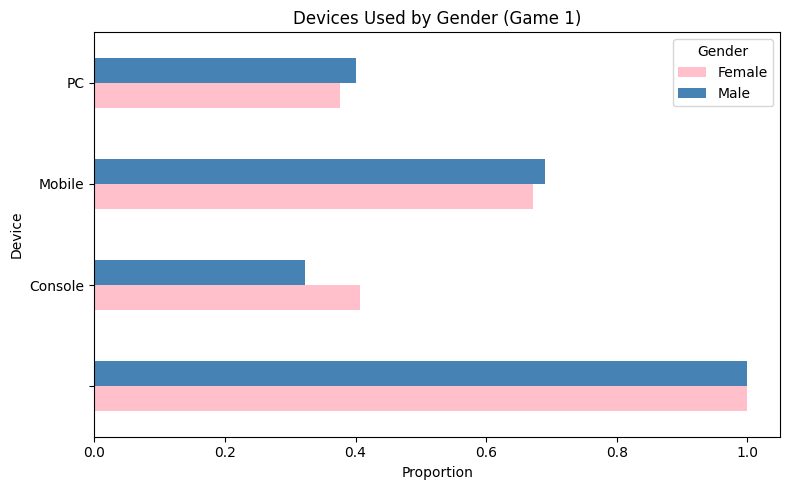

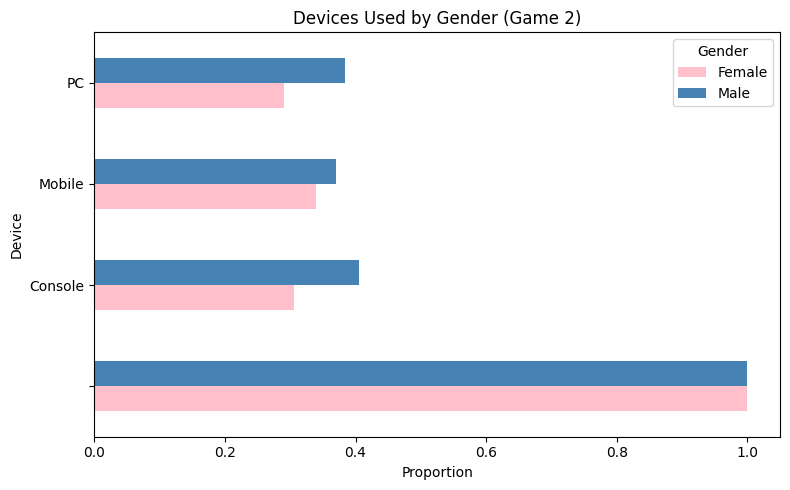

In [106]:
# Dispositivo más usado por género (Juego 1)
device01 = df_final.filter(like="device1_").copy()
device01["gender"] = df_final["gender"]

device01_grouped = device01.groupby("gender").mean().T
device01_grouped.index = device01_grouped.index.str.replace("device1_", "")

# Asegúrate de que el orden de columnas es ['Female', 'Male']
device01_grouped = device01_grouped[["Female", "Male"]]

# Gráfico
device01_grouped.plot(kind='barh', figsize=(8, 5), color=["pink", "steelblue"])
plt.title("Devices Used by Gender (Game 1)")
plt.xlabel("Proportion")
plt.ylabel("Device")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


# Dispositivo más usado por género (Juego 2)
device02 = df_final.filter(like="device2_").copy()
device02["gender"] = df_final["gender"]

device02_grouped = device02.groupby("gender").mean().T
device02_grouped.index = device02_grouped.index.str.replace("device2_", "")
device02_grouped = device02_grouped[["Female", "Male"]]

# Gráfico
device02_grouped.plot(kind='barh', figsize=(8, 5), color=["pink", "steelblue"])
plt.title("Devices Used by Gender (Game 2)")
plt.xlabel("Proportion")
plt.ylabel("Device")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


## 2.6. Géneros de videojuego preferidos por género

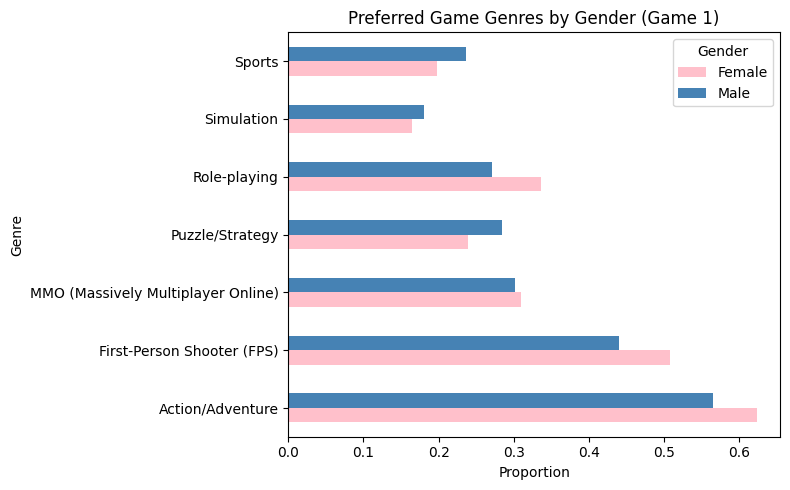

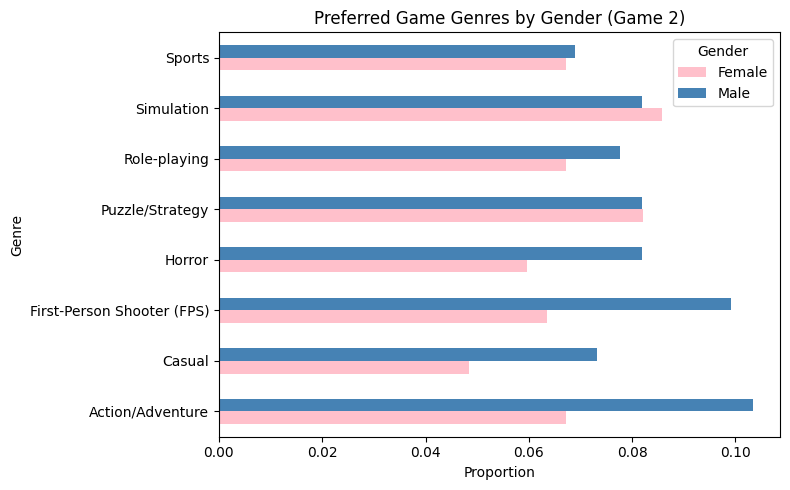

In [107]:
# Game 1 - Géneros preferidos por género
genre1 = df_final.filter(like="genre1_").copy()
genre1["gender"] = df_final["gender"]

# Agrupamos por género y calculamos proporciones
genre1_grouped = genre1.groupby("gender").mean().T
genre1_grouped.index = genre1_grouped.index.str.replace("genre1_", "")
genre1_grouped = genre1_grouped[["Female", "Male"]]  # Asegura el orden

# Gráfico
genre1_grouped.plot(
    kind="barh",
    figsize=(8, 5),
    color=["pink", "steelblue"]
)

plt.title("Preferred Game Genres by Gender (Game 1)")
plt.xlabel("Proportion")
plt.ylabel("Genre")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

# Game 2 - Géneros preferidos por género
genre2 = df_final.filter(like="genre2_").copy()
genre2["gender"] = df_final["gender"]

# Agrupamos por género y calculamos proporciones
genre2_grouped = genre2.groupby("gender").mean().T
genre2_grouped.index = genre2_grouped.index.str.replace("genre2_", "")
genre2_grouped = genre2_grouped[["Female", "Male"]]  # Asegura el orden

# Gráfico
genre2_grouped.plot(
    kind="barh",
    figsize=(8, 5),
    color=["pink", "steelblue"]
)

plt.title("Preferred Game Genres by Gender (Game 2)")
plt.xlabel("Proportion")
plt.ylabel("Genre")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


## 2.7. Comparativa dispositivos por rango de edad

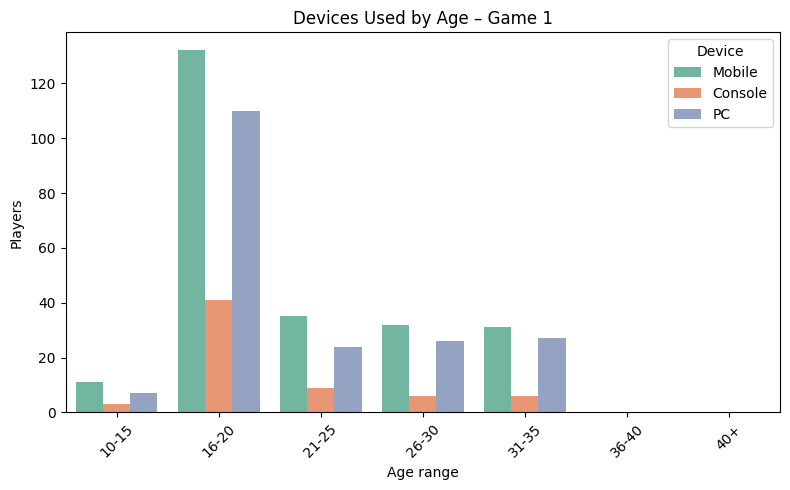

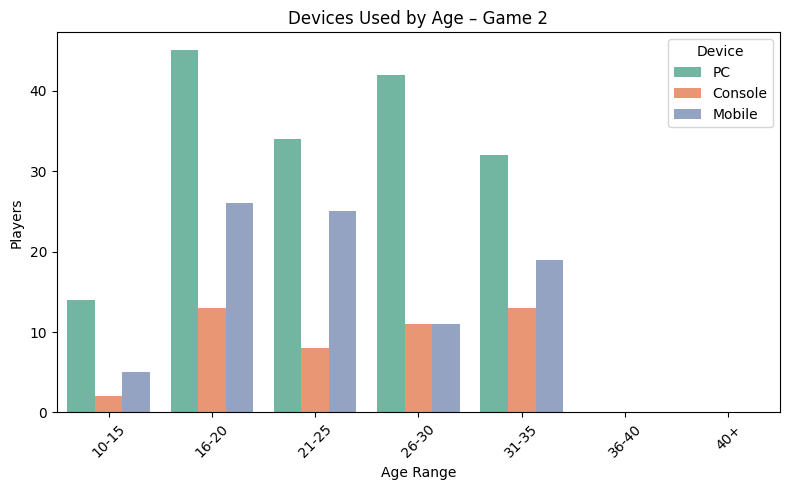

In [108]:
# Crear columna de dispositivo principal (PC / Console / Mobile)
df_final["device"] = df_final[["device1_PC", "device1_Console", "device1_Mobile"]].idxmax(axis=1)
df_final["device"] = df_final["device"].str.replace("device1_", "")

# Game 1
# Crear copia segura
df_game1 = df_final.copy()

# Crear columna con dispositivo principal
def get_device_game1(row):
    if row['device1_PC'] == 1:
        return 'PC'
    elif row['device1_Mobile'] == 1:
        return 'Mobile'
    elif row['device1_Console'] == 1:
        return 'Console'

df_game1['device_main'] = df_game1.apply(get_device_game1, axis=1)

# Gráfica
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_game1,
    x='age_group',
    hue='device_main',
    palette='Set2'
)
plt.title("Devices Used by Age – Game 1")
plt.xlabel("Age range")
plt.ylabel("Players")
plt.xticks(rotation=45)
plt.legend(title="Device")
plt.tight_layout()
plt.show()

# Game 2
# Crear copia segura
df_game2 = df_final.copy()

# Crear columna con dispositivo principal
def get_device_game2(row):
    if row['device2_PC'] == 1:
        return 'PC'
    elif row['device2_Mobile'] == 1:
        return 'Mobile'
    elif row['device2_Console'] == 1:
        return 'Console'

df_game2['device_main'] = df_game2.apply(get_device_game2, axis=1)

# Gráfica
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_game2,
    x='age_group',
    hue='device_main',
    palette='Set2'
)
plt.title("Devices Used by Age – Game 2")
plt.xlabel("Age Range")
plt.ylabel("Players")
plt.xticks(rotation=45)
plt.legend(title="Device")
plt.tight_layout()
plt.show()



## 2.8. Juegos favoritos

In [109]:
# Juegos favoritos elección nº1
df_final.filter(like='favorite_game1_').sum().sort_values(ascending=False)

favorite_game1_Call Of Duty             91
favorite_game1_Wuthering Waves          66
favorite_game1_Solo Leveling            45
favorite_game1_Efootball                43
favorite_game1_Bgmi                     42
favorite_game1_Chess                    40
favorite_game1_FC Mobile                23
favorite_game1_Subway                   23
favorite_game1_Wukong                   23
favorite_game1_Free Fire                22
favorite_game1_MOBA Legends             22
favorite_game1_Rhythm Rush Lite         22
favorite_game1_Fortnite                 20
favorite_game1_Clash Of Clans           20
favorite_game1_Many                     20
favorite_game1_Red Dead Redemption 2    20
favorite_game1_God Of War Ragnarok      20
dtype: int64

In [110]:
# Juegos favoritos elección nº2
df_final.filter(like='favorite_game2_').sum().sort_values(ascending=False)

favorite_game2_Fifa 2024            42
favorite_game2_Call Of Duty         39
favorite_game2_Overwatch            35
favorite_game2_League Of Legends    31
favorite_game2_Minecraft            29
favorite_game2_Apex Legends         27
favorite_game2_Genshin Impact       27
favorite_game2_Fortnite             26
favorite_game2_Among Us             22
favorite_game2_Valorant             22
dtype: int64

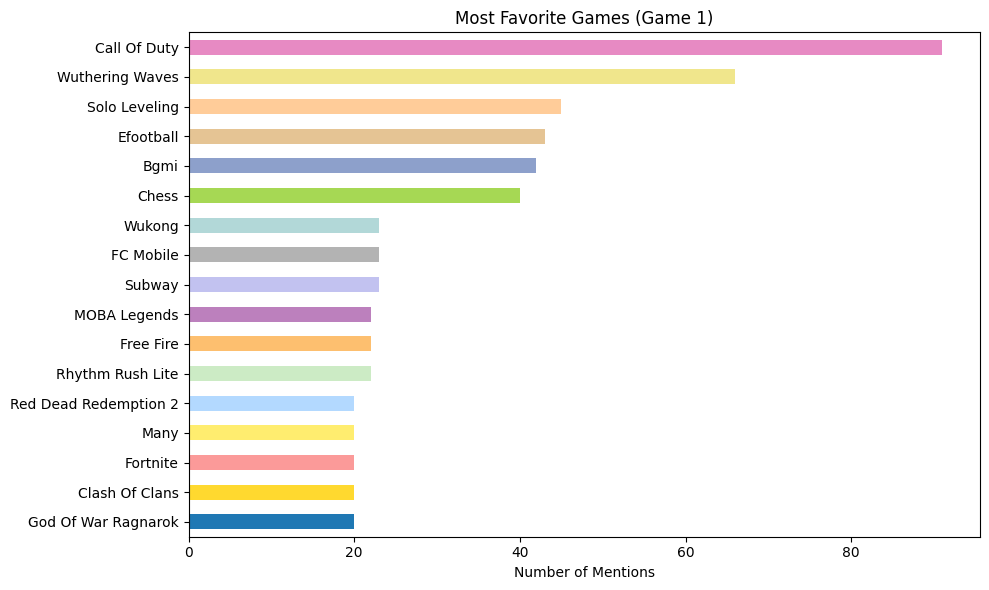

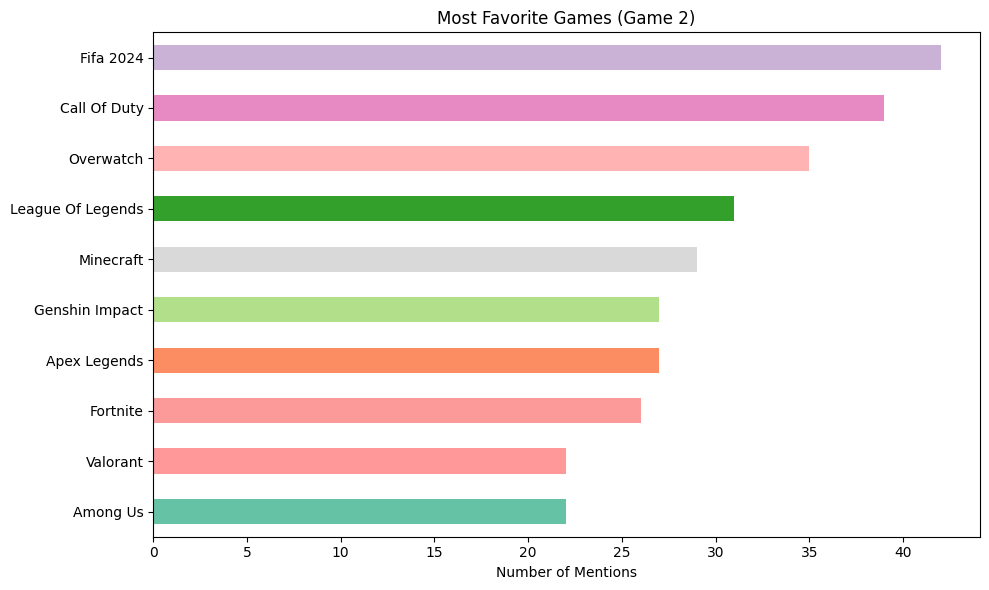

In [111]:
# Paso 1: Extraer datos agregados por juego
data1 = df_final.filter(like='favorite_game1_').sum()
data2 = df_final.filter(like='favorite_game2_').sum()

# Paso 2: Limpiar nombres de columnas
data1.index = data1.index.str.replace('favorite_game1_', '', regex=False)
data2.index = data2.index.str.replace('favorite_game2_', '', regex=False)

# Paso 3: Orden descendente
data1 = data1.sort_values(ascending=True)
data2 = data2.sort_values(ascending=True)

# Paso 4: Crear paleta de colores coherente para todos los juegos combinados
todos_los_juegos = sorted(set(data1.index) | set(data2.index))

paleta = [
    '#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854',
    '#ffd92f', '#e5c494', '#b3b3b3', '#cab2d6', '#fb9a99',
    '#fdbf6f', '#b2df8a', '#1f78b4', '#33a02c', '#bc80bd',
    '#ffed6f', '#d9d9d9', '#ffb3b3', '#b3d9ff', '#ccebc5',
    '#ffcc99', '#c2c2f0', '#ff9999', '#b2d8d8', '#f0e68c'
][:len(todos_los_juegos)]

colores_dict = dict(zip(todos_los_juegos, paleta))

# Paso 5: Generar listas de colores para cada gráfico
colores1 = [colores_dict[juego] for juego in data1.index]
colores2 = [colores_dict[juego] for juego in data2.index]

# Paso 6: Plot Game 1
data1.plot(kind='barh', figsize=(10, 6), color=colores1)
plt.title('Most Favorite Games (Game 1)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()

# Paso 7: Plot Game 2
data2.plot(kind='barh', figsize=(10, 6), color=colores2)
plt.title('Most Favorite Games (Game 2)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()



## 2.9. Modo de juego favorito

In [112]:
# 10. Modo de juego nº1
df_final.filter(like='game_mode1_').sum().sort_values(ascending=False)

game_mode1_Both             263
game_mode1_Multiplayer      155
game_mode1_Single-player     82
dtype: int64

In [113]:
# Modo de juego nº2
df_final.filter(like='game_mode2_').sum().sort_values(ascending=False)

game_mode2_Single-player    107
game_mode2_Multiplayer      103
game_mode2_Both              90
dtype: int64

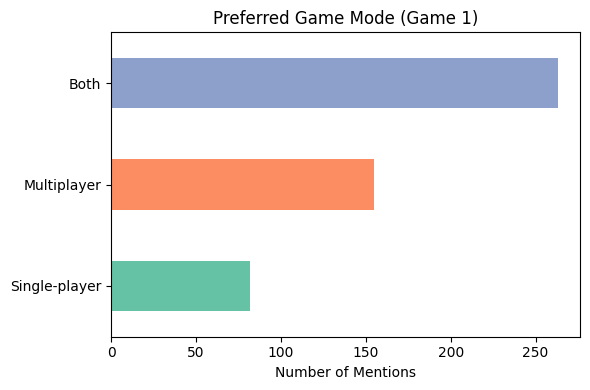

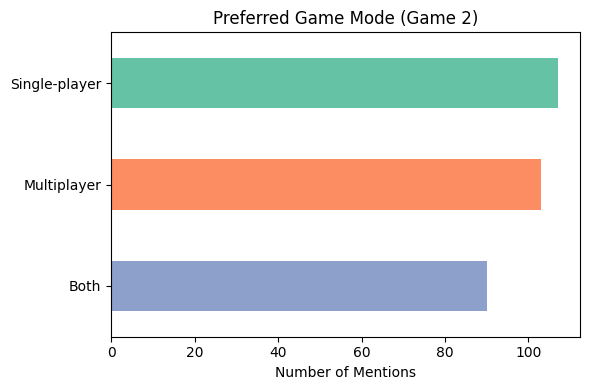

In [114]:
# Diccionario de colores fijos para los modos
colores_modos = {
    'Single-player': '#66c2a5',  
    'Multiplayer': '#fc8d62',  
    'Both': '#8da0cb'           
}

# GAME 1
data1 = df_final.filter(like='game_mode1_').sum()
data1.index = data1.index.str.replace('game_mode1_', '')
data1 = data1.sort_values()
colores1 = [colores_modos[modo] for modo in data1.index]

data1.plot(kind='barh', figsize=(6, 4), color=colores1)
plt.title('Preferred Game Mode (Game 1)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()

# GAME 2
data2 = df_final.filter(like='game_mode2_').sum()
data2.index = data2.index.str.replace('game_mode2_', '')
data2 = data2.sort_values()
colores2 = [colores_modos[modo] for modo in data2.index]

data2.plot(kind='barh', figsize=(6, 4), color=colores2)
plt.title('Preferred Game Mode (Game 2)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()



## 2.10. Fuentes de descubrimiento

In [115]:
# Descubrimiento juego nº1
df_final.filter(like='discovery1_').sum().sort_values(ascending=False)

discovery1_Social Media       263
discovery1_Gaming Forums      198
discovery1_Recommendations    167
discovery1_Twitch             128
discovery1_YouTube            128
discovery1_ReviewsBlogs       107
discovery1_Other               40
dtype: int64

In [116]:
# Descubrimiento juego nº2
df_final.filter(like='discovery2_').sum().sort_values(ascending=False)

discovery2_YouTube            69
discovery2_Social Media       67
discovery2_Twitch             60
discovery2_Gaming Forums      55
discovery2_Recommendations    49
discovery2_ReviewsBlogs        0
dtype: int64

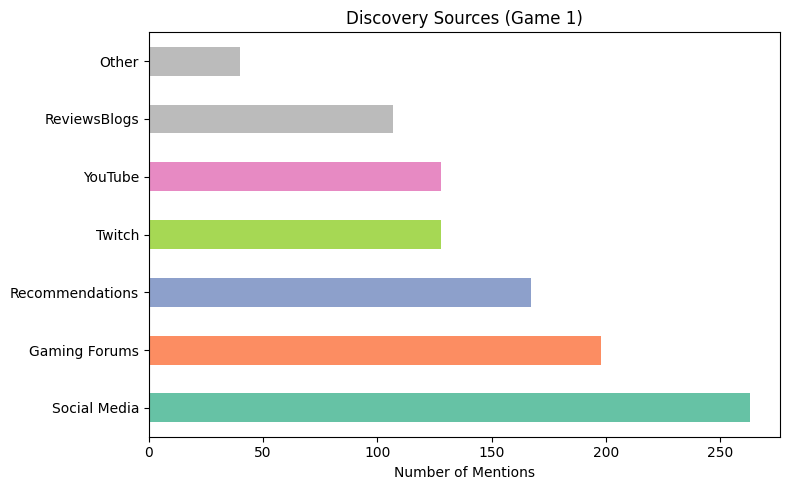

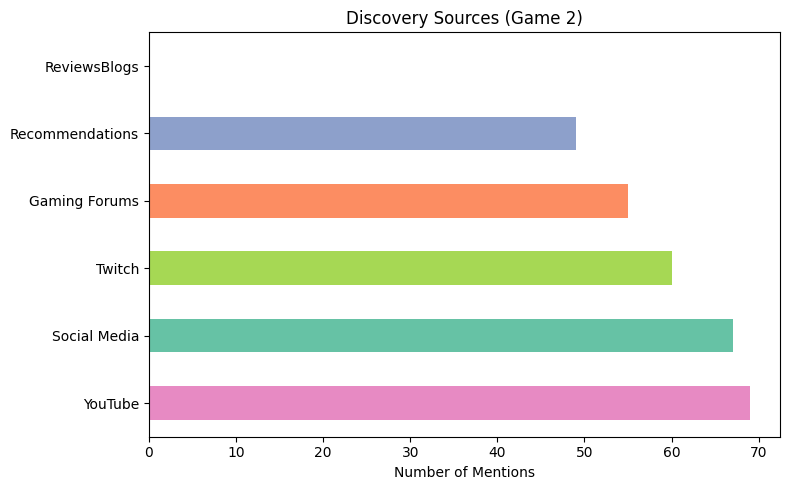

In [117]:
colores_fuentes = {
    'Social Media': '#66c2a5',
    'Gaming Forums': '#fc8d62',
    'Recommendations': '#8da0cb',
    'YouTube': '#e78ac3',
    'Twitch': '#a6d854',
    'Reviews/Blogs': '#ffd92f',
}

# GAME 1 - Discovery Sources
data1 = df_final.filter(like='discovery1_').sum()
data1.index = data1.index.str.replace('discovery1_', '')
data1 = data1.sort_values(ascending=False)

colores1 = [colores_fuentes.get(source, '#bbbbbb') for source in data1.index]

data1.plot(kind='barh', figsize=(8, 5), color=colores1)
plt.title('Discovery Sources (Game 1)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()

# GAME 2 - Discovery Sources
data2 = df_final.filter(like='discovery2_').sum()
data2.index = data2.index.str.replace('discovery2_', '')
data2 = data2.sort_values(ascending=False)

colores2 = [colores_fuentes.get(source, '#bbbbbb') for source in data2.index]

data2.plot(kind='barh', figsize=(8, 5), color=colores2)
plt.title('Discovery Sources (Game 2)')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()


## 🎯 3. Perfil general del jugador que más horas dedica

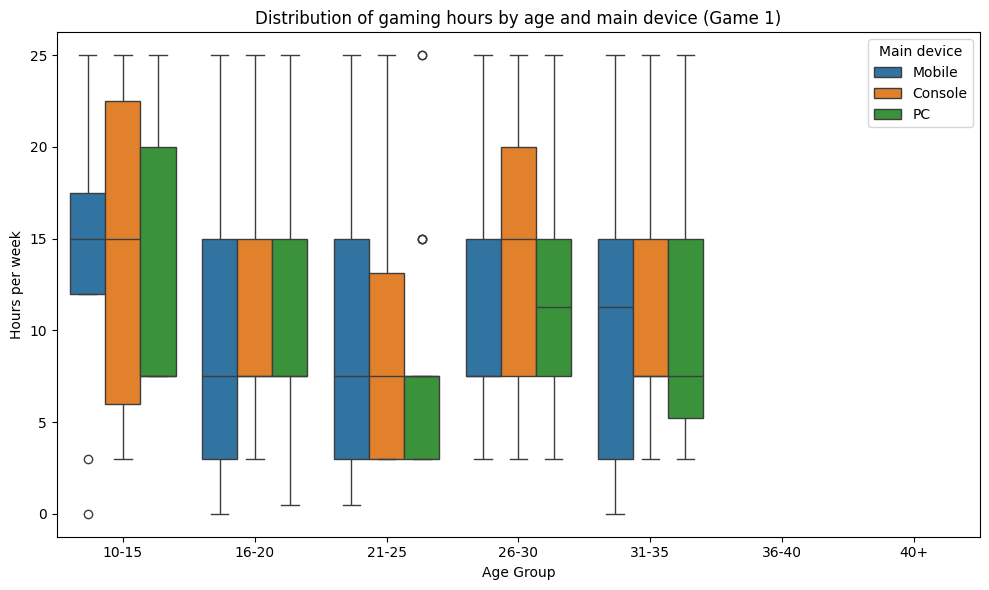

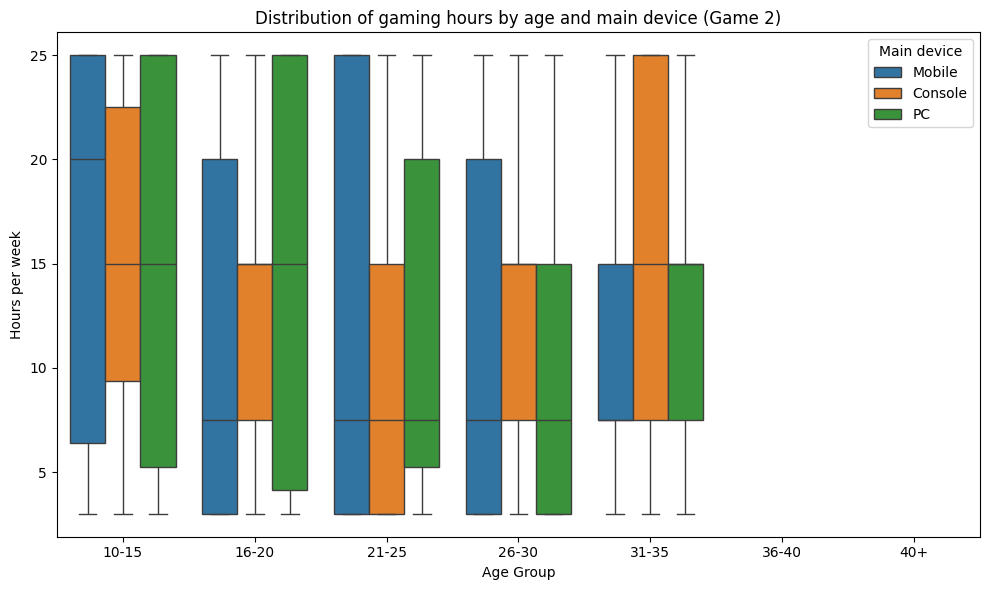

In [118]:
# Crear columna de dispositivo principal (PC / Console / Mobile)
df_final["device"] = df_final[["device1_PC", "device1_Console", "device1_Mobile"]].idxmax(axis=1)
df_final["device"] = df_final["device"].str.replace("device1_", "")


# Convertir categorías de horas a valores numéricos estimados
horas_map = {
    "Less than 1 hour": 0.5,
    "0 hours": 0,
    "1–5 hours": 3,
    "5–10 hours": 7.5,
    "10–20 hours": 15,
    "More than 20 hours": 25
}

# Game 1
df_final["hours_per_week_1_num"] = df_final["hours_per_week_1"].map(horas_map)

# Eliminar filas sin datos numéricos de horas o edad
df_box = df_final.dropna(subset=["hours_per_week_1_num", "age_group", "device"])

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, x="age_group", y="hours_per_week_1_num", hue="device")
plt.title("Distribution of gaming hours by age and main device (Game 1)")
plt.xlabel("Age Group")
plt.ylabel("Hours per week")
plt.legend(title="Main device", loc="upper right")
plt.tight_layout()
plt.show()

# Game 2

df_final["hours_per_week_2_num"] = df_final["hours_per_week_2"].map(horas_map)

# Eliminar filas sin datos numéricos de horas o edad
df_box = df_final.dropna(subset=["hours_per_week_2_num", "age_group", "device"])

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, x="age_group", y="hours_per_week_2_num", hue="device")
plt.title("Distribution of gaming hours by age and main device (Game 2)")
plt.xlabel("Age Group")
plt.ylabel("Hours per week")
plt.legend(title="Main device", loc="upper right")
plt.tight_layout()
plt.show()



In [119]:
# Horas activas según género
# Game 1
df_final["horas_numericas"] = df_final["hours_per_week_1"].map(horas_map)

# Agrupar por género y calcular la media de horas
media_por_genero = df_final.groupby("gender")["horas_numericas"].mean().sort_values(ascending=False)

print(media_por_genero)

# Game 2
# Horas activas según género
df_final["horas_numericas_2"] = df_final["hours_per_week_2"].map(horas_map)

# Agrupar por género y calcular la media de horas
media_por_genero_2 = df_final.groupby("gender")["horas_numericas_2"].mean().sort_values(ascending=False)

print(media_por_genero_2)


gender
Female    11.248134
Male      11.021552
Name: horas_numericas, dtype: float64
gender
Female    12.824138
Male      12.487097
Name: horas_numericas_2, dtype: float64


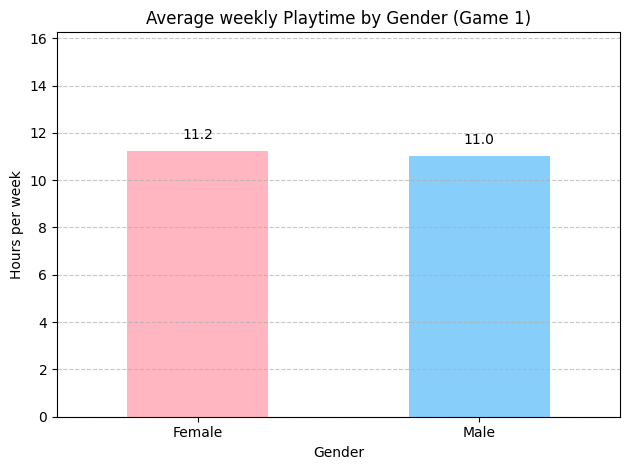

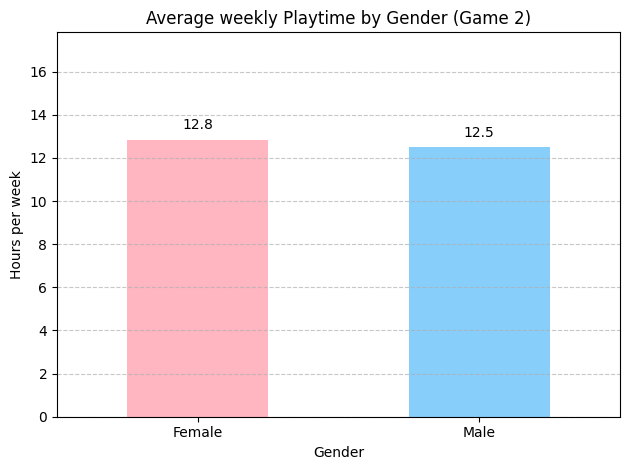

In [120]:
# Game 1
media_por_genero.plot(kind='bar', color=['#ffb6c1', '#87cefa'])  # Colores: rosa y azul claro

plt.title("Average weekly Playtime by Gender (Game 1)")
plt.ylabel("Hours per week")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, max(media_por_genero) + 5)  # Límite superior dinámico
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valor numérico encima de cada barra
for i, valor in enumerate(media_por_genero):
    plt.text(i, valor + 0.5, f'{valor:.1f}', ha='center')

plt.tight_layout()
plt.show()

# Game 2
media_por_genero_2.plot(kind='bar', color=['#ffb6c1', '#87cefa'])  # Colores: rosa y azul claro

plt.title("Average weekly Playtime by Gender (Game 2)")
plt.ylabel("Hours per week")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, max(media_por_genero_2) + 5)  # Límite superior dinámico
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valor numérico encima de cada barra
for i, valor in enumerate(media_por_genero_2):
    plt.text(i, valor + 0.5, f'{valor:.1f}', ha='center')

plt.tight_layout()
plt.show()
